In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit 
from sklearn.preprocessing import OneHotEncoder

from Bio import pairwise2
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ElasticNet


from sklearn import preprocessing
from Bio.SeqUtils.ProtParam import ProteinAnalysis


from Bio import AlignIO
from Bio import SeqIO
from Bio.Align.Applications import MuscleCommandline
from Bio.Align import AlignInfo
import pandascharm as pc

from Bio.SubsMat.MatrixInfo import blosum62
from Bio.SubsMat.MatrixInfo import blosum45


from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr


import warnings 
warnings.filterwarnings('ignore') 
  

C:\Users\memre\anaconda3\Lib\site-packages\Bio\SubsMat\__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  warnings.warn(


In [2]:
def removeoutlier_col(df,cols):
    Q1 = df[cols].quantile(0.25)
    Q3 = df[cols].quantile(0.75)
    IQR = Q3 - Q1
    df_out = df[~((df[[cols]] < (Q1 - 1.5 * IQR)) |(df[[cols]] > (Q3 + 1.5 * IQR))).any(axis=1)]
    return df_out

In [3]:
#Sequence Representation Methods

blosum62.update(((b,a),val) for (a,b),val in list(blosum62.items()))
blosum45.update(((b,a),val) for (a,b),val in list(blosum45.items()))

def score_pairwise(seq1, seq2, matrix, gap_s, gap_e, gap = True):
    for A,B in zip(seq1, seq2):
        diag = ('-'==A) or ('-'==B)
        yield (gap_e if gap else gap_s) if diag else matrix[(A,B)]
        gap = diag

In [4]:
def encode(encoding, output, df_clean, aln, esm1b ,key = None):
    
    df_clean = df_clean.set_index('Index')
    
    ClustalAlign = AlignIO.read(aln, 'fasta')
    summary_align = AlignInfo.SummaryInfo(ClustalAlign )
    dframe = pc.from_bioalignment(ClustalAlign).transpose()
    sequences = dframe.loc[df_clean.index]
    
    y = df_clean[output]

    if encoding == 'One_Hot_Encoder':

        one_hot = OneHotEncoder()
        encoded = one_hot.fit(sequences)
        X = encoded.transform(sequences).toarray()

           
    if encoding == 'Bag_of_Words':

        X = pd.DataFrame([ProteinAnalysis(i).count_amino_acids() for i in df_clean['Sequence']])
        X = np.array(X)
        
    if encoding == 'bigram':
        
        X = df_clean['Sequence']
        example = df_clean['Sequence'][0]
        lst = ['E','G','L','Y','T','H','R','A','C','D','P','I','F','N','K','S','V','M','W','Q']
        all_dct = {}
        key = []
        for i in lst:
            for j in lst:
                st = i+j
                all_dct[st] = []

        for example, id in zip(X,range(len(X))):

            temp = list(example)
            temp_dct = dict.fromkeys(all_dct.keys(),0)
            for k in range(len(temp)-1):
                try:
                    check = temp[k] + temp[k+1]
                    temp_dct[check] += 1
                except:
                    pass
            for key, value in temp_dct.items():
                all_dct[key].append(value)
                
                
        X = pd.DataFrame.from_dict(all_dct).set_index(df_clean.index)
        X = np.array(X)
    
    if encoding == 'trigram':
        
        X = df_clean['Sequence']

        example = df_clean['Sequence'][0]
        lst = ['E','G','L','Y','T','H','R','A','C','D','P','I','F','N','K','S','V','M','W','Q']
        all_dct = {}
        key = []
        for i in lst:
            for j in lst:
                for k in lst:
                    st = i+j+k
                    all_dct[st] = []

        for example, id in zip(X,range(len(X))):

            temp = list(example)
            temp_dct = dict.fromkeys(all_dct.keys(),0)
            for k in range(len(temp)-2):
                try:
                    check = temp[k] + temp[k+1]+temp[k+2]
                    temp_dct[check] += 1
                except:
                    pass
            for key, value in temp_dct.items():
                all_dct[key].append(value)
                
        X = pd.DataFrame.from_dict(all_dct).set_index(df_clean.index)
        X = np.array(X)

        
    if encoding == 'quadrogram':
        
        X = df_clean['Sequence']

        example = df_clean['Sequence'][0]
        lst = ['E','G','L','Y','T','H','R','A','C','D','P','I','F','N','K','S','V','M','W','Q']
        all_dct = {}
        key = []
        for i in lst:
            for j in lst:
                for k in lst:
                    for l in lst:
                        st = i+j+k+l
                        all_dct[st] = []

        for example, id in zip(X,range(len(X))):

            temp = list(example)
            temp_dct = dict.fromkeys(all_dct.keys(),0)
            for k in range(len(temp)-3):
                try:
                    check = temp[k] + temp[k+1]+temp[k+2]+temp[k+3]
                    temp_dct[check] += 1
                except:
                    pass
            for key, value in temp_dct.items():
                all_dct[key].append(value)
                
        X = pd.DataFrame.from_dict(all_dct).set_index(df_clean.index)
        X = np.array(X)


    if encoding == 'BLOSUM62':

        n = len(sequences)
        enc_seq = np.zeros((n,n))

        i = 0

        for a in list(sequences.index):
            j = 0
            for b in list(sequences.index):
                enc_seq[i,j] = sum(score_pairwise(sequences.loc[a], sequences.loc[b], blosum62, -5, -1))
                j += 1
            i += 1

        X = np.array(enc_seq)

        
        
        
    if encoding == 'BLOSUM45':
        
        n = len(sequences)
        enc_seq = np.zeros((n,n))

        i = 0

        for a in list(sequences.index):
            j = 0
            for b in list(sequences.index):
                enc_seq[i,j] = sum(score_pairwise(sequences.loc[a], sequences.loc[b], blosum45, -5, -1))
                j += 1
            i += 1
        X = np.array(enc_seq)
      
        
    if encoding == 'ESM1b':

        encoded = esm1b.loc[df_clean.index]
        X = np.array(encoded)

        
    return X
        

In [5]:
#Sequence Representation Methods with Temperature

def encode_temp(encoding, output, df_clean, aln, esm1b , temperature):
    
    df_clean = df_clean.set_index('Index')
    
    ClustalAlign = AlignIO.read(aln, 'fasta')
    summary_align = AlignInfo.SummaryInfo(ClustalAlign )
    dframe = pc.from_bioalignment(ClustalAlign).transpose()
    sequences = dframe.loc[df_clean.index]
    
    y = df_clean['Percentage Activity Depending on Optimum Temp']


    if encoding == 'One_Hot_Encoder':

        one_hot = OneHotEncoder()
        encoded = one_hot.fit(sequences)
        sequences_encoded = encoded.transform(sequences).toarray()
        X = np.concatenate((sequences_encoded,df_clean[[temperature]]), axis =1)

        
           
    if encoding == 'Bag_of_Words':

        X = pd.DataFrame([ProteinAnalysis(i).count_amino_acids() for i in df_clean['Sequence']])
        X = np.concatenate((X,df_clean[[temperature]]), axis =1)

        
    if encoding == 'bigram':
        
        X = df_clean['Sequence']

        example = df_clean['Sequence'][0]
        lst = ['E','G','L','Y','T','H','R','A','C','D','P','I','F','N','K','S','V','M','W','Q']
        all_dct = {}
        key = []
        for i in lst:
            for j in lst:
                st = i+j
                all_dct[st] = []

        for example, id in zip(X,range(len(X))):

            temp = list(example)
            temp_dct = dict.fromkeys(all_dct.keys(),0)
            for k in range(len(temp)-1):
                try:
                    check = temp[k] + temp[k+1]
                    temp_dct[check] += 1
                except:
                    pass
            for key, value in temp_dct.items():
                all_dct[key].append(value)
                
                
        X = pd.DataFrame.from_dict(all_dct).set_index(df_clean.index)
        X = np.concatenate((X,df_clean[[temperature]]), axis =1)

    
    if encoding == 'trigram':
        
        X = df_clean['Sequence']

        example = df_clean['Sequence'][0]
        lst = ['E','G','L','Y','T','H','R','A','C','D','P','I','F','N','K','S','V','M','W','Q']
        all_dct = {}
        key = []
        for i in lst:
            for j in lst:
                for k in lst:
                    st = i+j+k
                    all_dct[st] = []

        for example, id in zip(X,range(len(X))):

            temp = list(example)
            temp_dct = dict.fromkeys(all_dct.keys(),0)
            for k in range(len(temp)-2):
                try:
                    check = temp[k] + temp[k+1]+temp[k+2]
                    temp_dct[check] += 1
                except:
                    pass
            for key, value in temp_dct.items():
                all_dct[key].append(value)
                
        X = pd.DataFrame.from_dict(all_dct).set_index(df_clean.index)
        X = np.concatenate((X,df_clean[[temperature]]), axis =1)

        
        
    if encoding == 'quadrogram':
        
        X = df_clean['Sequence']

        example = df_clean['Sequence'][0]
        lst = ['E','G','L','Y','T','H','R','A','C','D','P','I','F','N','K','S','V','M','W','Q']
        all_dct = {}
        key = []
        for i in lst:
            for j in lst:
                for k in lst:
                    for l in lst:
                        st = i+j+k+l
                        all_dct[st] = []

        for example, id in zip(X,range(len(X))):

            temp = list(example)
            temp_dct = dict.fromkeys(all_dct.keys(),0)
            for k in range(len(temp)-3):
                try:
                    check = temp[k] + temp[k+1]+temp[k+2]+temp[k+3]
                    temp_dct[check] += 1
                except:
                    pass
            for key, value in temp_dct.items():
                all_dct[key].append(value)
                
        X = pd.DataFrame.from_dict(all_dct).set_index(df_clean.index)
        
        X = np.concatenate((X,df_clean[[temperature]]), axis =1)

    if encoding == 'BLOSUM62':

        n = len(sequences)
        enc_seq = np.zeros((n,n))

        i = 0

        for a in list(sequences.index):
            j = 0
            for b in list(sequences.index):
                enc_seq[i,j] = sum(score_pairwise(sequences.loc[a], sequences.loc[b], blosum62, -5, -1))
                j += 1
            i += 1

        X = np.concatenate((enc_seq,df_clean[[temperature]]), axis =1)

        
    if encoding == 'BLOSUM45':
        
        n = len(sequences)
        enc_seq = np.zeros((n,n))

        i = 0

        for a in list(sequences.index):
            j = 0
            for b in list(sequences.index):
                enc_seq[i,j] = sum(score_pairwise(sequences.loc[a], sequences.loc[b], blosum45, -5, -1))
                j += 1
            i += 1

        X = np.concatenate((enc_seq,df_clean[[temperature]]), axis =1)

        
    if encoding == 'ESM1b':
        

        encoded = esm1b.loc[df_clean.index]
        X = np.concatenate((encoded,df_clean[[temperature]]), axis =1)

        
    return X, y

In [6]:
def ml_algorithm(algorithm, X_train, y_train, X_val):

    if algorithm == 'Random Forest':

        model = RandomForestRegressor(random_state = 42)
        model.fit(X_train,np.ravel(y_train))
        prediction = model.predict(X_val)


    if algorithm == 'XGBoost':

        model = xgb.XGBRegressor()
        model.fit(X_train, y_train)
        prediction = model.predict(X_val)
            
    if algorithm == 'LASSO':

        model = Lasso()
        model.fit(X_train, y_train)
        prediction = model.predict(X_val)
        
    if algorithm == 'SVR':

        model =  SVR()
        model.fit(X_train, y_train)
        prediction = model.predict(X_val)

    if algorithm == 'Neural Network':
        
        model = MLPRegressor(random_state=101, max_iter=100)
        model.fit(X_train, y_train)
        prediction = model.predict(X_val)
        
    if algorithm == 'Elastic Net':
        
        model = ElasticNet()
        model.fit(X_train, y_train)
        prediction = model.predict(X_val)
        
    return model, prediction

In [7]:
enzyme = 'betaGlucosidasewithMutants'

df = pd.read_excel('betaGlucosidasewithMutantsOptimumTemperatureHybrid.xlsx')

output = 'pNP-Glc kcat/Km (1/smM)'
aln = 'betaGlucosidasewithMutantsHybrid.fa'

x = datetime.datetime.now()
date = str(x.year)+str(x.month)+str(x.day)

df['Log'+output] = np.log10(df[output])
esm1b = pd.read_excel('betaGlucosidasewithMutantsHybridESM1b_embeddings.xlsx', index_col = 0)

random_state = [202 , 1, 42, 101, 2022,5 , 10, 22, 1995, 0]


In [8]:
model_list = [[['XGBoost', 'ESM1b'],['SVR', 'ESM1b'], ['Random Forest', 'Bag_of_Words']],
             [['XGBoost', 'ESM1b'],['SVR', 'ESM1b'], ['Random Forest', 'BLOSUM45']],
             [['Random Forest', 'Bag_of_Words'],['SVR', 'ESM1b'], ['Elastic Net','quadrogram']],
             [['Random Forest', 'Bag_of_Words'],['SVR', 'ESM1b'], ['Elastic Net','trigram']]]

In [9]:
import joblib

# Function to save model
def save_model(model, model_name):
    joblib.dump(model, f'{model_name}.joblib')

# Function to load model
def load_model(model_name):
    return joblib.load(f'{model_name}.joblib')

In [ ]:
list_final_results = []
list_df_val = []
combinations =[]
list_predicted_optimum_temperature = []
list_predicted_maximum_activity = []
list_predicted_relative_activity = []


list_final_results_train = []
list_df_train = []
list_predicted_optimum_temperature_train = []
list_predicted_maximum_activity_train = []
list_predicted_relative_activity_train = []

list_final_results_hybrid = []
list_df_hybrid = []
list_predicted_optimum_temperature_hybrid = []
list_predicted_maximum_activity_hybrid = []
list_predicted_relative_activity_hybrid = []


for state in random_state:
    
    for models in model_list:
        
        model_1_list= [models[0]]
        model_2_list= [models[1]]
        model_3_list= [models[2]]
        
        df['Relative Temperature'] = df['Reaction Temperature'] - df["Temperature Optimum"]
        
        df_ancestor = df.tail(6)
        df_clean = removeoutlier_col(df.iloc[:-6],'Log' + output).reset_index()
        
        # Create a mapping of unique sequences to unique codes
        sequence_to_code = {seq: f"ENZYME_{i+1}" for i, seq in enumerate(df_clean['Sequence'].unique())}

        # Map these codes to a new column in the DataFrame using .loc
        df_clean.loc[:, 'Sequence Code'] = df_clean['Sequence'].map(sequence_to_code)

        splitter = GroupShuffleSplit(test_size=.20, n_splits=10, random_state = state)

        split = splitter.split(df_clean, groups=df_clean['Sequence Code'])

        train_inds, val_inds = next(split)

        train_inds_unique = df_clean.iloc[train_inds][df_clean.iloc[train_inds]['Percentage Activity Depending on Optimum Temp']==1].index

        val_inds_unique = df_clean.iloc[val_inds][df_clean.iloc[val_inds]['Percentage Activity Depending on Optimum Temp']==1].index


        df_clean = pd.concat([df_clean, df_ancestor], ignore_index=True)
        hybrid_inds = df_clean.tail(6).index

        X_ESM1b  = encode('ESM1b', 'Temperature Optimum', df_clean, aln, esm1b)
        X_BLOSUM45 = encode('BLOSUM45', 'Temperature Optimum', df_clean, aln, esm1b)[:,:-6]
        X_trigram  = encode('trigram', 'Temperature Optimum', df_clean, aln, esm1b)
        X_quadrogram  = encode('quadrogram', 'Temperature Optimum', df_clean, aln, esm1b)
        X_Bag_of_Words  = encode('Bag_of_Words', 'Temperature Optimum', df_clean, aln, esm1b)

        sequence_dictionary = {'ESM1b': X_ESM1b,'BLOSUM45': X_BLOSUM45,'trigram' : X_trigram,'quadrogram': X_quadrogram, 
       'Bag_of_Words' : X_Bag_of_Words}
    

        for model1_algorithm, model1_method  in model_1_list:
            model_name_1 = f'{model1_method}_{model1_algorithm}_optimum_temperature_state_{state}'
            model_1 = load_model(model_name_1)

            X_val_temperature = sequence_dictionary[model1_method][val_inds]
            X_train_temperature = sequence_dictionary[model1_method][train_inds]
            X_hybrid_temperature = sequence_dictionary[model1_method][hybrid_inds]

            if model1_algorithm in ['LASSO', 'SVR', 'Neural Network']:
                scaler = preprocessing.StandardScaler()
                scaler.fit(sequence_dictionary[model1_method][:-6])
                X_val_temperature = scaler.transform(X_val_temperature)
                X_train_temperature = scaler.transform(X_train_temperature)
                X_hybrid_temperature = scaler.transform(X_hybrid_temperature)

            prediction_Topt = model_1.predict(X_val_temperature)
            predict_train_Topt = model_1.predict(X_train_temperature)
            predict_hybrid_Topt = model_1.predict(X_hybrid_temperature)
            

            for model2_algorithm, model2_method  in model_2_list:
                model_name_2 = f'{model2_method}_{model2_algorithm}_maximum_activity_state_{state}'
                model_2 = load_model(model_name_2)

                X_val_activity = sequence_dictionary[model2_method][val_inds]
                X_train_activity = sequence_dictionary[model2_method][train_inds]
                X_hybrid_activity = sequence_dictionary[model2_method][hybrid_inds]
                

                if model2_algorithm in ['LASSO', 'SVR', 'Neural Network']:
                    scaler = preprocessing.StandardScaler()
                    scaler.fit(sequence_dictionary[model2_method][:-6])

                    X_val_activity  = scaler.transform(X_val_activity) 
                    X_train_activity = scaler.transform(X_train_activity)
                    X_hybrid_activity = scaler.transform(X_hybrid_activity)

                prediction_MaxActivity = model_2.predict(X_val_activity)
                prediction_train_MaxActivity = model_2.predict(X_train_activity)
                prediction_hybrid_MaxActivity = model_2.predict(X_hybrid_activity)


                for model3_algorithm, model3_method in model_3_list: 
                    model_name_3 = f'{model3_method}_{model3_algorithm}_temperature_profile_state_{state}'
                    model_3 = load_model(model_name_3)

                    df_val = df_clean.iloc[val_inds]
                    y_val_activity = df_val['Log' +'pNP-Glc kcat/Km (1/smM)']
                    
                    df_train = df_clean.iloc[train_inds]
                    y_train_activity = df_train['Log' +'pNP-Glc kcat/Km (1/smM)']
                    
                    df_hybrid = df_clean.iloc[hybrid_inds]
                    y_hybrid_activity = df_hybrid['Log' +'pNP-Glc kcat/Km (1/smM)']

                    relative_temperature = prediction_Topt- df_val['Reaction Temperature'].values
                    relative_temperature_train = predict_train_Topt- df_train['Reaction Temperature'].values
                    relative_temperature_hybrid = predict_hybrid_Topt- df_hybrid['Reaction Temperature'].values
                    
                    X_val = np.concatenate((sequence_dictionary[model3_method][val_inds], relative_temperature.reshape(-1, 1)), axis=1)
                    X_train = np.concatenate((sequence_dictionary[model3_method][train_inds], relative_temperature_train.reshape(-1, 1)), axis=1)
                    X_hybrid = np.concatenate((sequence_dictionary[model3_method][hybrid_inds], relative_temperature_hybrid.reshape(-1, 1)), axis=1)
                    
                    y_val_predicted = model_3.predict(X_val)
                    y_val_predicted[y_val_predicted < 0] = 0.01
                    
                    y_train_predicted = model_3.predict(X_train)
                    y_train_predicted[y_train_predicted < 0] = 0.01
                    
                    y_hybrid_predicted = model_3.predict(X_hybrid)
                    y_hybrid_predicted[y_hybrid_predicted < 0] = 0.01

                    results = np.log10(y_val_predicted * (10**prediction_MaxActivity))
                    results_train = np.log10(y_train_predicted * (10**prediction_train_MaxActivity))
                    results_hybrid = np.log10(y_hybrid_predicted * (10**prediction_hybrid_MaxActivity))


                    df_val['Log Predicted kcat/Km'] = results
                    df_val['Predicted kcat/Km'] = 10**results
                    
                    df_train['Log Predicted kcat/Km'] = results_train
                    df_train['Predicted kcat/Km'] = 10**results_train
                    
                    df_hybrid['Log Predicted kcat/Km'] = results_hybrid
                    df_hybrid['Predicted kcat/Km'] = 10**results_hybrid

                    list_predicted_relative_activity.append(y_val_predicted)
                    list_final_results.append(results)
                    
                    list_df_val.append(df_val)
                    list_predicted_optimum_temperature.append(prediction_Topt)
                    list_predicted_maximum_activity.append(prediction_MaxActivity)

                    list_predicted_relative_activity_train.append(y_train_predicted)
                    list_final_results_train.append(results_train)
                    
                    list_df_train.append(df_train)
                    list_predicted_optimum_temperature_train.append(predict_train_Topt)
                    list_predicted_maximum_activity_train.append(prediction_train_MaxActivity)
                    
                    
                    list_predicted_relative_activity_hybrid.append(y_hybrid_predicted)
                    list_final_results_hybrid.append(results_hybrid)
                    
                    list_df_hybrid.append(df_hybrid)
                    list_predicted_optimum_temperature_hybrid.append(predict_hybrid_Topt)
                    list_predicted_maximum_activity_hybrid.append(prediction_hybrid_MaxActivity)   
                    
                    
                    combination = 'Model 1:'+ model1_method + ' with ' + model1_algorithm + ', and ' +  'Model 2:'+ model2_method + ' with ' + model2_algorithm + ', and ' + 'Model 3:'+ model3_method +' with ' + model3_algorithm + '_'+ str(state)

                    combinations.append(combination)
                    
                    print(combination)
                    print(str(state))
    

In [10]:
import datetime
x = datetime.datetime.now()
date = str(x.year)+str(x.month)+str(x.day)

In [ ]:
df_predicted_optimum_temperature = pd.DataFrame(list_predicted_optimum_temperature, index = combinations).transpose()
df_predicted_maximum_activity = pd.DataFrame(list_predicted_maximum_activity, index = combinations).transpose()
df_predicted_relative_activity = pd.DataFrame(list_predicted_relative_activity, index = combinations).transpose()

In [ ]:
df_predicted_optimum_temperature_train = pd.DataFrame(list_predicted_optimum_temperature_train, index = combinations).transpose()
df_predicted_maximum_activity_train = pd.DataFrame(list_predicted_maximum_activity_train, index = combinations).transpose()
df_predicted_relative_activity_train = pd.DataFrame(list_predicted_relative_activity_train, index = combinations).transpose()

In [ ]:
df_predicted_optimum_temperature_hybrid = pd.DataFrame(list_predicted_optimum_temperature_hybrid, index = combinations).transpose()
df_predicted_maximum_activity_hybrid = pd.DataFrame(list_predicted_maximum_activity_hybrid, index = combinations).transpose()
df_predicted_relative_activity_hybrid = pd.DataFrame(list_predicted_relative_activity_hybrid, index = combinations).transpose()

In [ ]:


df_predicted_optimum_temperature.to_excel(date +  ' Predicted Optimum Temperature y_val values 3 Models Combined.xlsx')

df_predicted_maximum_activity.to_excel(date +  ' Predicted Maximum Activity y_val values Models 3 Combined.xlsx')

df_predicted_relative_activity.to_excel(date +  ' Predicted Relative Activity y_val values Models 3 Combined.xlsx')

In [ ]:


df_predicted_optimum_temperature_train.to_excel(date +  ' Predicted Training Optimum Temperature y_val values 3 Models Combined.xlsx')

df_predicted_maximum_activity_train.to_excel(date +  ' Predicted Training Maximum Activity y_val values Models 3 Combined.xlsx')

df_predicted_relative_activity_train.to_excel(date + ' Predicted Training Relative Activity y_val values Models 3 Combined.xlsx')

In [ ]:


df_predicted_optimum_temperature_hybrid.to_excel(date +  ' Predicted hybrid Optimum Temperature y_val values 3 Models Combined.xlsx')

df_predicted_maximum_activity_hybrid.to_excel(date +  ' Predicted hybrid Maximum Activity y_val values Models 3 Combined.xlsx')

df_predicted_relative_activity_hybrid.to_excel(date + ' Predicted hybrid Relative Activity y_val values Models 3 Combined.xlsx')

In [11]:
names = ['Trial 1', 'Trial 2', 'Trial 3', 'Trial 4', 'Trial 5', 'Trial 6', 'Trial 7', 'Trial 8', 'Trial 9', 'Trial 10']


In [ ]:
column_names = combinations[:4]

In [ ]:
list_df_train_predicted_activity = {}
i = 0
for name in names:
    list_df_train_predicted_activity[name] = pd.DataFrame(list_final_results_train[:][i:i+4], index = column_names).transpose()
    i = i + 4

list_df_hybrid_predicted_activity = {}
i = 0
for name in names:
    list_df_hybrid_predicted_activity[name] = pd.DataFrame(list_final_results_hybrid[:][i:i+4], index = column_names).transpose()
    i = i + 4
    
list_df_predicted_activity = {}
i = 0
for name in names:
    list_df_predicted_activity[name] = pd.DataFrame(list_final_results[:][i:i+4], index = column_names).transpose()
    i = i + 4    

In [ ]:
# Specify the output Excel file name
output_file = '20250117 kcatKm prediction betaGlucosidase - y_val values predicted - 3 Models combined.xlsx'

# Write each dataframe to a separate sheet in the Excel workbook
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    for sheet_name, df in list_df_predicted_activity.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)

In [ ]:
# Specify the output Excel file name
output_file = '20250117 kcatKm prediction betaGlucosidase - y_train values predicted - 3 Models combined.xlsx'

# Write each dataframe to a separate sheet in the Excel workbook
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    for sheet_name, df in list_df_train_predicted_activity.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)

In [ ]:
# Specify the output Excel file name
output_file = '20250117 kcatKm prediction betaGlucosidase - y_hybrid values predicted - 3 Models combined.xlsx'

# Write each dataframe to a separate sheet in the Excel workbook
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    for sheet_name, df in list_df_hybrid_predicted_activity.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)

In [12]:
df_val = pd.read_excel('20250117 kcatKm prediction betaGlucosidase - y_val values predicted - 3 Models combined.xlsx', sheet_name= names, index_col=0)

In [13]:
df_train = pd.read_excel('20250117 kcatKm prediction betaGlucosidase - y_train values predicted - 3 Models combined.xlsx', sheet_name=names)

In [14]:
df_hybrid = pd.read_excel('20250117 kcatKm prediction betaGlucosidase - y_hybrid values predicted - 3 Models combined.xlsx', sheet_name=names, index_col=0)

In [15]:
#Collecting y-val values
y_val_list = []
y_train_list = []
train_ind_list = []
val_ind_list = []

for state in random_state:
    df_clean = removeoutlier_col(df.head(-6),'Log' + output).reset_index()

    # Create a mapping of unique sequences to unique codes
    sequence_to_code = {seq: f"ENZYME_{i+1}" for i, seq in enumerate(df_clean['Sequence'].unique())}

    # Map these codes to a new column in the DataFrame using .loc
    df_clean.loc[:, 'Sequence Code'] = df_clean['Sequence'].map(sequence_to_code)

    splitter = GroupShuffleSplit(test_size=.20, n_splits=10, random_state = state)

    split = splitter.split(df_clean, groups=df_clean['Sequence Code'])

    train_inds, val_inds = next(split)
    
    y_val_list.append(df_clean.iloc[val_inds]['Log'+output].values)
    y_train_list.append(df_clean.iloc[train_inds]['Log'+output].values)
    train_ind_list.append(train_inds)
    val_ind_list.append(val_inds)

In [16]:
i = 0
for name in names:
    df_val[name]['y value'] = y_val_list[i]
    df_train[name]['y value'] = y_train_list[i]
    i = i + 1

In [17]:
#Combining Training and Validation
list_df_entire_predicted_activity = {}

for i in names:  # Iterate over each split
    combined_df = pd.concat([df_train[i], df_val[i]])  # Keep original indices
    list_df_entire_predicted_activity[i] = combined_df

In [18]:
data_set = [df_val , df_train, list_df_entire_predicted_activity]
dataset_types = ["Validation", "Training", "Entire"]

In [19]:
# Metric lists for storing results
list_R2_df = []
list_RMSE_df = []
list_MAE_df = []
list_PCC_df = []
list_pValue_df = []

i =1

# Process each dataset (validation, training, entire)
for data, dataset_type in zip(data_set, dataset_types):
    list_R2, list_RMSE, list_MAE, list_PCC, list_pValue = [], [], [], [], []

    # Loop through each split in the dataset dictionary
    for state_key in data:
        state = data[state_key]  # Access the DataFrame

        r2_list, rmse_list, mae_list, pcc_list, pvalue_list = [], [], [], [], []

        # Calculate metrics for each model in the dataframe
        for model in state.columns[:-1]:  # Assuming 'y_val' is the last column
            r2 = r2_score(state['y value'], state[model])
            rmse = mean_squared_error(state['y value'], state[model])**0.5
            mae = mean_absolute_error(state['y value'], state[model])
            pcc, pValue = pearsonr(state['y value'], state[model])

            r2_list.append(r2)
            rmse_list.append(rmse)
            mae_list.append(mae)
            pcc_list.append(pcc)
            pvalue_list.append(pValue)

        # Append results for this split
        list_R2.append(r2_list)
        list_RMSE.append(rmse_list)
        list_MAE.append(mae_list)
        list_PCC.append(pcc_list)
        list_pValue.append(pvalue_list)
        
    column_names = state.columns[:-1]

    # Convert metric lists to DataFrames for each split
    Results_R2 = pd.DataFrame(list_R2, columns=column_names, index = names)
    Results_RMSE = pd.DataFrame(list_RMSE, columns=column_names,index = names)
    Results_MAE = pd.DataFrame(list_MAE, columns=column_names, index = names)
    Results_PCC = pd.DataFrame(list_PCC, columns=column_names, index = names)
    Results_pValue = pd.DataFrame(list_pValue, columns=column_names, index = names)

    # Append each metric's result DataFrame
    list_R2_df.append(Results_R2)
    list_RMSE_df.append(Results_RMSE)
    list_MAE_df.append(Results_MAE)
    list_PCC_df.append(Results_PCC)
    list_pValue_df.append(Results_pValue)

In [ ]:
# Function to write metrics to Excel file with specified structure
def write_metrics_to_excel(filename, metric_dfs, metric_name):
    with pd.ExcelWriter(filename) as writer:
        # Initialize empty DataFrames for validation, training, and entire dataset results

        # Select the first four columns for Validation
        validation_df = metric_dfs[0]

        # Select the next four columns for Training
        training_df = metric_dfs[1]

        # Select the last four columns for Entire
        entire_df =metric_dfs[2]

        # Write each dataset type to a separate sheet
        validation_df.to_excel(writer, sheet_name="Validation", index=False)
        training_df.to_excel(writer, sheet_name="Training", index=False)
        entire_df.to_excel(writer, sheet_name="Entire", index=False)

        # Calculate the average across the 10 trials for each dataset type
        avg_validation = validation_df.mean(axis=0)
        avg_training = training_df.mean(axis=0)
        avg_entire = entire_df.mean(axis=0)

        
        model_names =  validation_df.columns
        # Create DataFrames for average values
        avg_validation_df = pd.DataFrame(avg_validation, columns=['Average'], index = model_names)
        avg_training_df = pd.DataFrame(avg_training, columns=['Average'], index = model_names)
        avg_entire_df = pd.DataFrame(avg_entire, columns=['Average'], index = model_names)

        # Write average values to separate sheets
        avg_validation_df.to_excel(writer, sheet_name="Avg_Validation")
        avg_training_df.to_excel(writer, sheet_name="Avg_Training",)
        avg_entire_df.to_excel(writer, sheet_name="Avg_Entire")

        # Calculate the standard deviation across the 10 trials for each dataset type
        std_validation = validation_df.std(axis=0)
        std_training = training_df.std(axis=0)
        std_entire = entire_df.std(axis=0)

        # Create DataFrames for standard deviation values
        std_validation_df = pd.DataFrame(std_validation, columns=['Std_Dev'], index = model_names)
        std_training_df = pd.DataFrame(std_training, columns=['Std_Dev'], index = model_names)
        std_entire_df = pd.DataFrame(std_entire, columns=['Std_Dev'], index = model_names)

        # Write standard deviation values to separate sheets
        std_validation_df.to_excel(writer, sheet_name="Std_Validation")
        std_training_df.to_excel(writer, sheet_name="Std_Training")
        std_entire_df.to_excel(writer, sheet_name="Std_Entire")


In [ ]:
from datetime import datetime
current_date = datetime.now().strftime("%Y%m%d")

# Write each metric to separate Excel files with date in the filename
for metric_dfs, metric_name in zip(
        [list_R2_df, list_RMSE_df, list_MAE_df, list_PCC_df, list_pValue_df],
        ["R2", "RMSE", "MAE", "PCC", "pValue"]):
    filename = f"{current_date}_{metric_name}_3ModelCombinedResults_.xlsx"
    write_metrics_to_excel(filename, metric_dfs, metric_name)

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
def reaction_analyzer(sequence, df, model, df_predicted_optimum_temperature,r2, trial):
    sns.set(font_scale=1.5)
    sns.set_style("ticks")
    
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelweight"] = "bold"
    plt.rcParams['axes.linewidth'] = 5
    plt.rcParams['ytick.major.width'] = 4
    plt.rcParams['ytick.minor.width'] = 2
    plt.rcParams['xtick.major.width'] = 4

    fig, ax1 = plt.subplots(figsize=(10, 8))
    ax2 = ax1.twinx()

    df['Name'] = df['Organism Name Actual'] + ' (' + df['Mutation'].fillna('') + ')'
    organism_name = df[df['Sequence'] == sequence]['Name'].unique()

    # Scatter plots
    scatter1 = sns.scatterplot(data=df[df['Sequence'] == sequence], y='pNP-Glc kcat/Km (1/smM)', x='Reaction Temperature', marker="o", s=400, color="blue", ax=ax1)
    
    scatter2 = sns.scatterplot(data=df[df['Sequence'] == sequence], y=model, x='Reaction Temperature', marker="^", s=400, color="red", ax=ax2)
    ax1.set_title(model +"\n" + organism_name[0] + 'R2: '+ str(r2) + ', '+trial, pad =40)
    
    
    ax1.set_xlabel("Reaction Temperature ($^\circ$C)")
    ax1.set_ylabel('Reported $k$$_{\\rm cat}$/$K$$_{\\rm m}$ (mM$^{-1}$s$^{-1}$)', color='b')
    ax2.set_ylabel('Predicted $k$$_{\\rm cat}$/$K$$_{\\rm m}$ (mM$^{-1}$s$^{-1}$)', color='r')

    ymin1, ymax1 = ax1.get_ylim()
    ymin2, ymax2 = ax2.get_ylim()
    training_range = [ymin1 , ymax1]

#    optimum_temperature = np.mean(df[df['Sequence'] == sequence]['Temperature Optimum'])
#    ax1.plot([optimum_temperature, optimum_temperature], training_range, '--b', label='Optimum Temperature')

#    predicted_optimum_temperature = np.mean(df_predicted_optimum_temperature[df_predicted_optimum_temperature['Sequence'] == sequence][model])
#    ax1.plot([predicted_optimum_temperature, predicted_optimum_temperature], training_range, '--r', label='Predicted Optimum Temperature')

    # Create dummy legend handles for scatter plots
    from matplotlib.lines import Line2D
    handles = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Reported kcat/Km'),
        Line2D([0], [0], marker='^', color='w', markerfacecolor='red', markersize=10, label='Predicted kcat/Km')
    ]

    # Get other legend handles and labels from the plots
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles.extend(handles1)
    handles2, labels2 = ax2.get_legend_handles_labels()
    handles.extend(handles2)

    labels = ['Reported kcat/Km', 'Predicted kcat/Km'] + labels1 + labels2

    ax1.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.1, 1))
    name_organism = organism_name[0].replace('/', ',')
    plt.savefig('C:\\Users\\memre\\Desktop\\Sequence\\' + 
                model_name.replace(':', '').replace(' ', '').replace(',', '').replace('_', '').replace(':', '').replace('Model', '') 
                + trial + name_organism.replace(' ', '') 
                + '.png',  bbox_inches='tight')
    
    plt.show()

In [22]:
model_name_list = df_val['Trial 1'].columns[:-1]

In [23]:
model_name_list

Index(['Model 1:ESM1b with XGBoost, and Model 2:ESM1b with SVR, and Model 3:Bag_of_Words with Random Forest_202',
       'Model 1:ESM1b with XGBoost, and Model 2:ESM1b with SVR, and Model 3:BLOSUM45 with Random Forest_202',
       'Model 1:Bag_of_Words with Random Forest, and Model 2:ESM1b with SVR, and Model 3:quadrogram with Elastic Net_202',
       'Model 1:Bag_of_Words with Random Forest, and Model 2:ESM1b with SVR, and Model 3:trigram with Elastic Net_202'],
      dtype='object')

In [24]:
y_hybrid_value = df.tail(6)['LogpNP-Glc kcat/Km (1/smM)']
df_concat = pd.concat(df_hybrid, axis=0)

# Compute mean and std for each cell
df_hybrid_mean = df_concat.groupby(level=1).mean()
df_hybrid_std = df_concat.groupby(level=1).std(ddof=0)

In [26]:
def plot_models(y_predicted, y_val, combinations, r2, trial, y_hybrid_value, df_hybrid_mean,df_hybrid_std):

    #logaritmic scale, Combined Models

    sns.set(font_scale=1.5)
    from matplotlib import ticker as mticker

    sns.set_style("ticks")
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelweight"] = "bold"

    plt.rcParams['axes.linewidth'] =  5
    plt.rcParams['ytick.major.width'] =  4
    plt.rcParams['ytick.minor.width'] =  2
    plt.rcParams['xtick.major.width'] =  4


    fig, ax = plt.subplots(figsize=(7.5, 7.5))

    sns.scatterplot(y=y_predicted, x = y_val, s=200)

    sns.scatterplot(y=df_hybrid_mean, x = y_hybrid_value, s= 200, facecolors="none", linewidth=3, edgecolors="red")
#    plt.errorbar(y=df_hybrid_mean, x = y_hybrid_value, yerr=df_hybrid_std, fmt='none', color="red", ecolor="black", capsize=5, elinewidth=3)


    ax.set(xlabel="Reported $k$$_{\\rm cat}$/$K$$_{\\rm m}$ (mM$^{-1}$s$^{-1}$)",
       ylabel= "Predicted $k$$_{\\rm cat}$/$K$$_{\\rm m}$ (mM$^{-1}$s$^{-1}$)")

    ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
    ymin, ymax = ax.get_ylim()
    tick_range = np.arange(ymin, ymax)
    ax.yaxis.set_ticks([np.log10(y) for p in tick_range for y in np.linspace(10 ** p, 10 ** (p + 1), 10)], minor=True)


    ax.xaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
    xmin, xmax = ax.get_xlim()
    tick_range = np.arange(xmin, xmax)
    ax.xaxis.set_ticks([np.log10(x) for p in tick_range for x in np.linspace(10 ** p, 10 ** (p + 1), 10)], minor=True)



    val_range=[min(ymin, xmin),max(ymax,xmax)]  

    plt.xlim(val_range)
    plt.ylim(val_range)
    plt.title(combinations + ' ' + trial +' R2 value: ' + str(round(r2,3)), pad =40)

    plt.plot(val_range, val_range, '--k')
    plt.savefig(date +' CombinedModel '+ trial + ' ' + combinations + '.png',  bbox_inches='tight')

    plt.show()

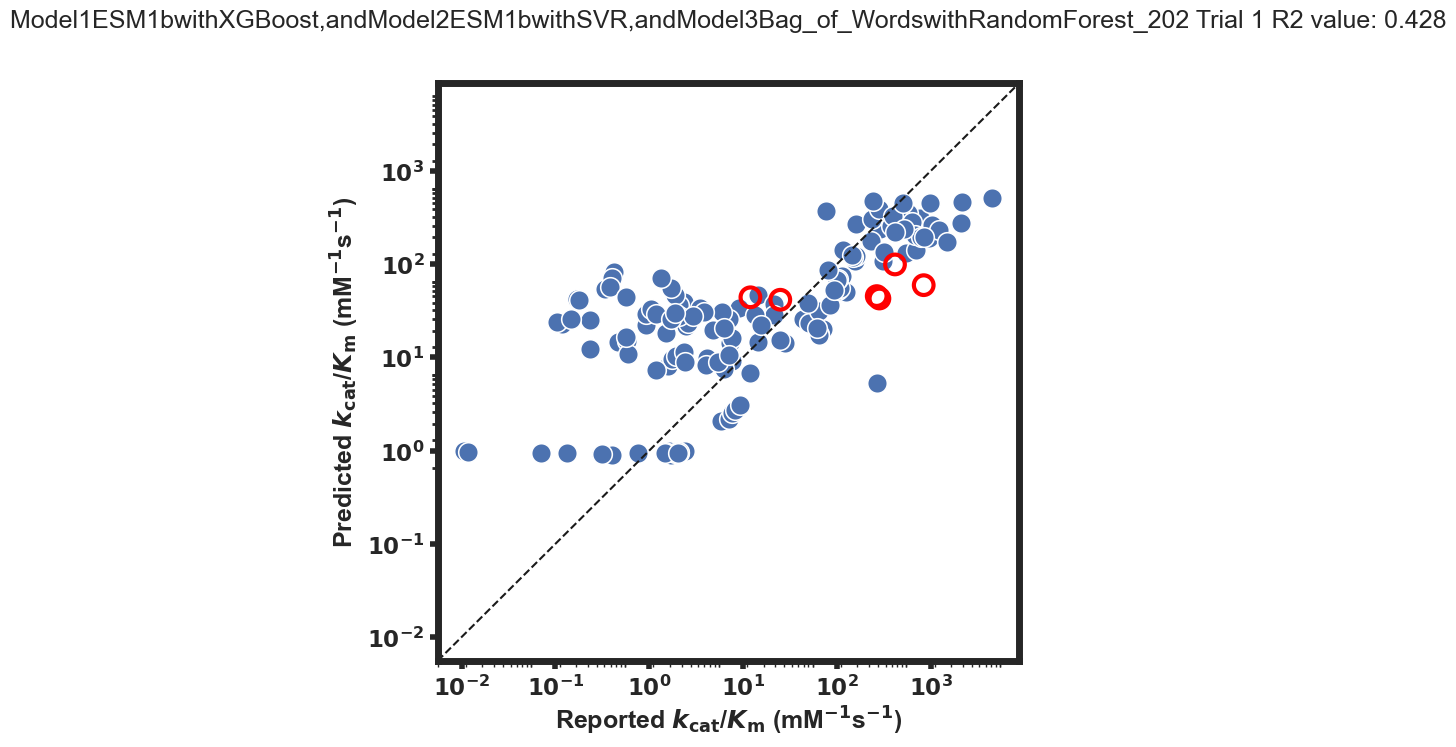

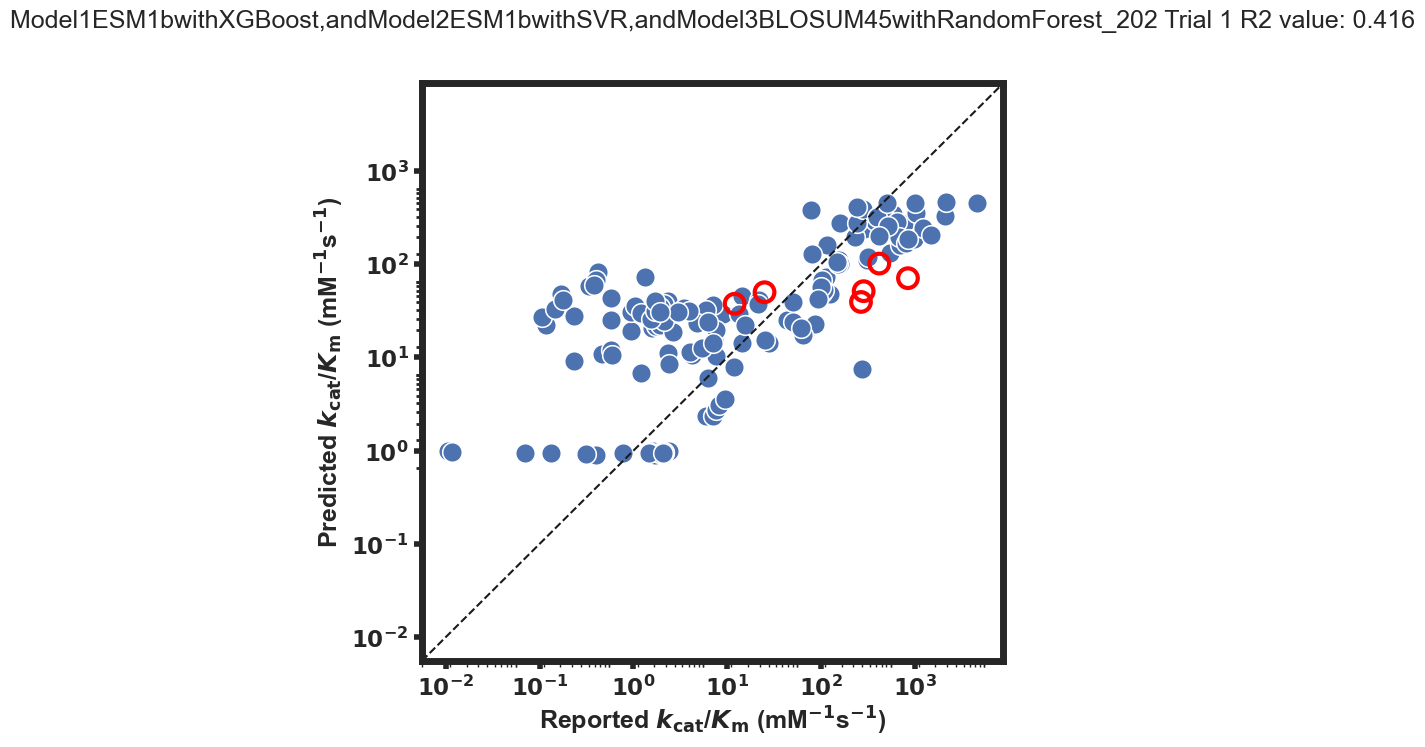

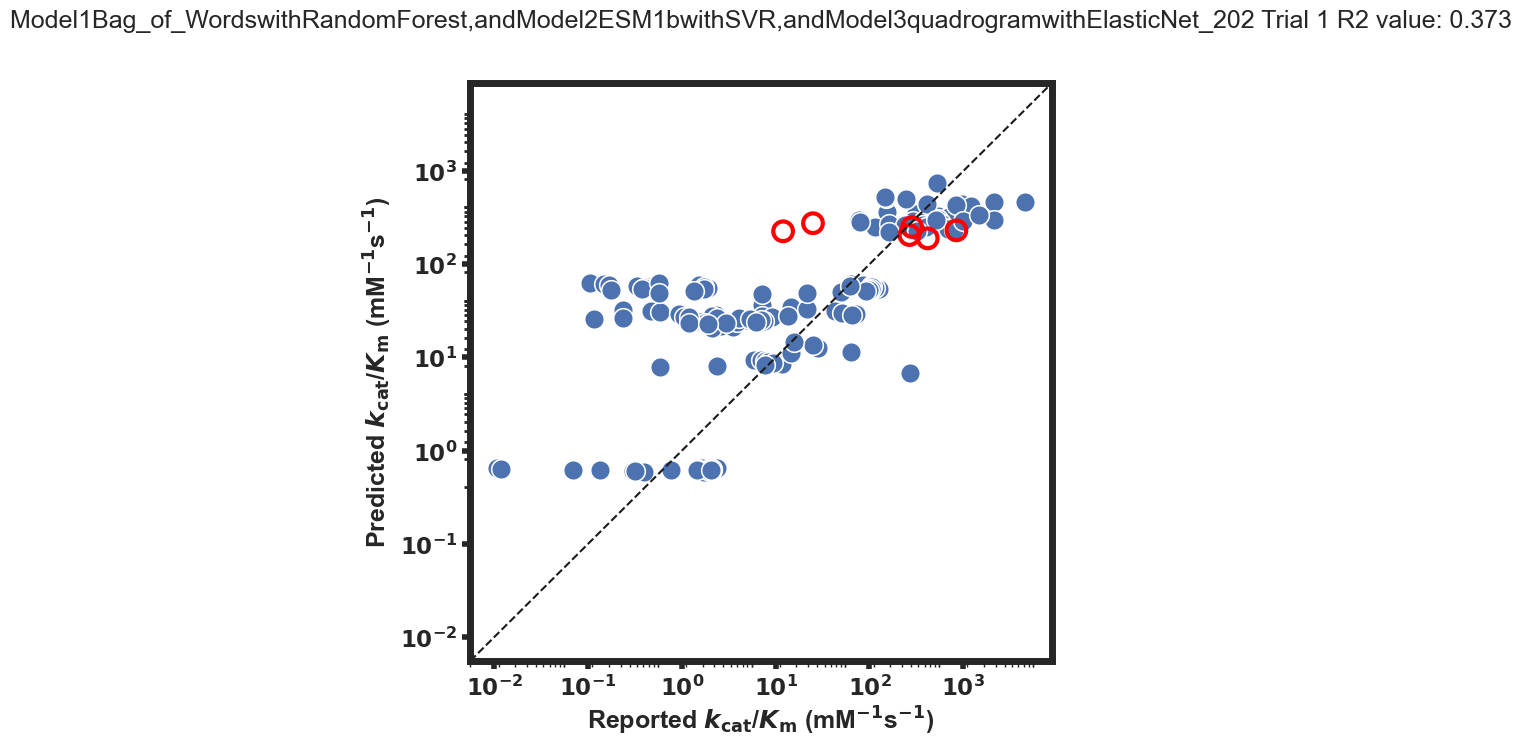

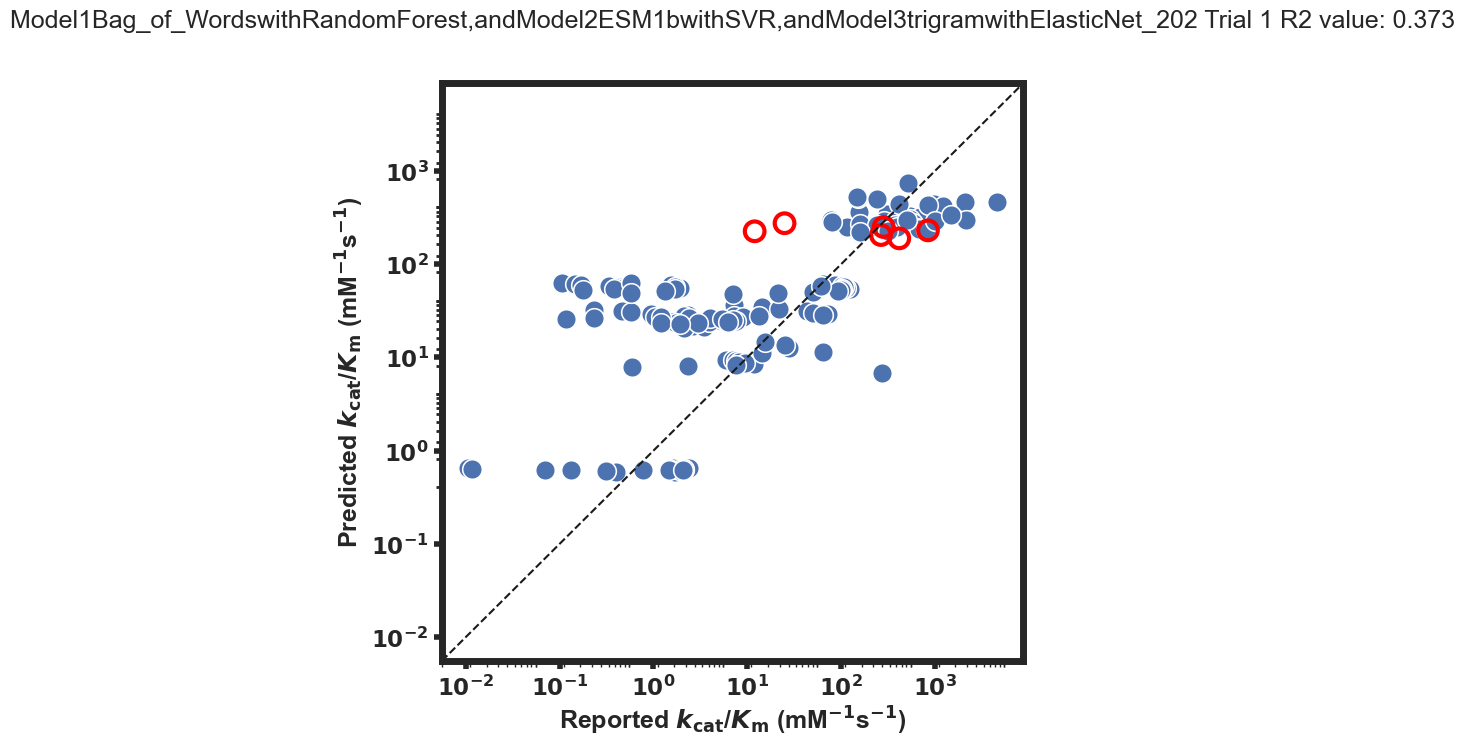

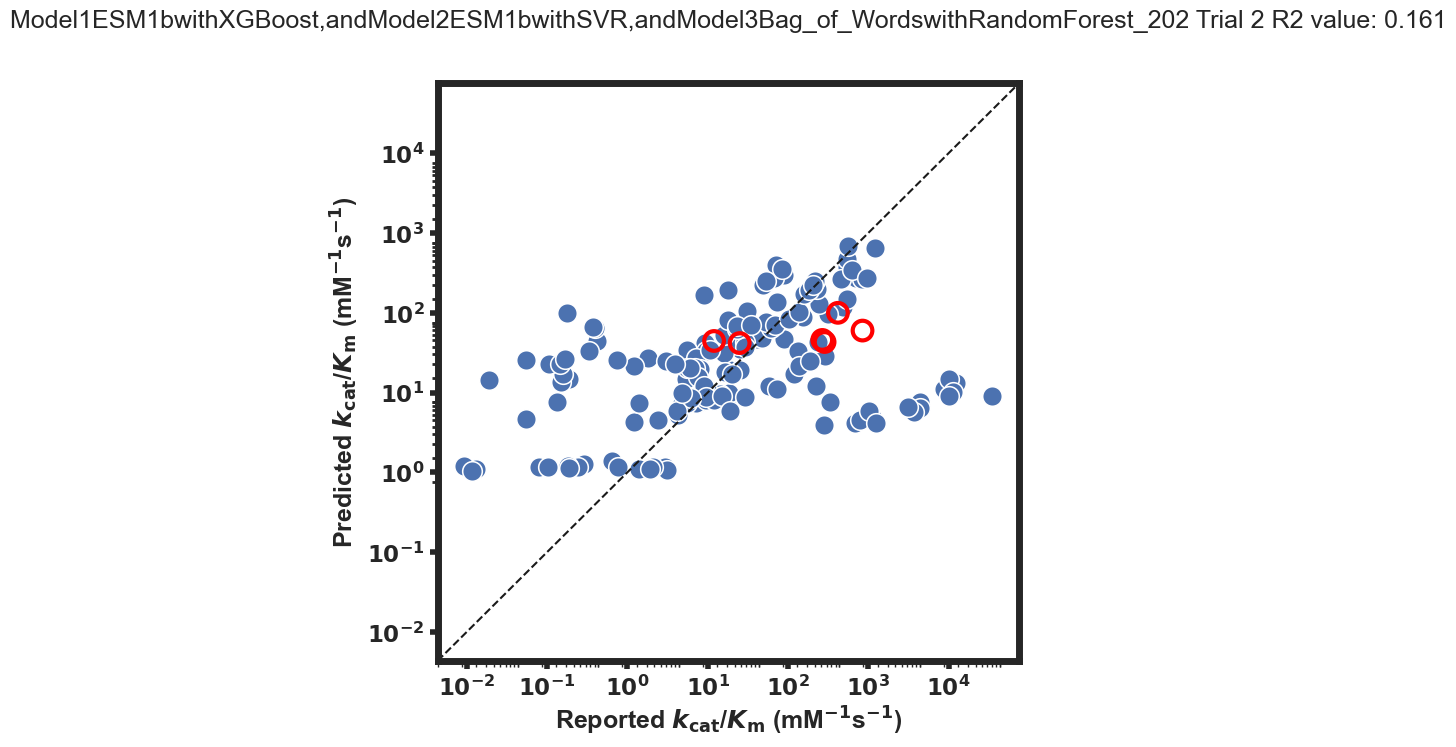

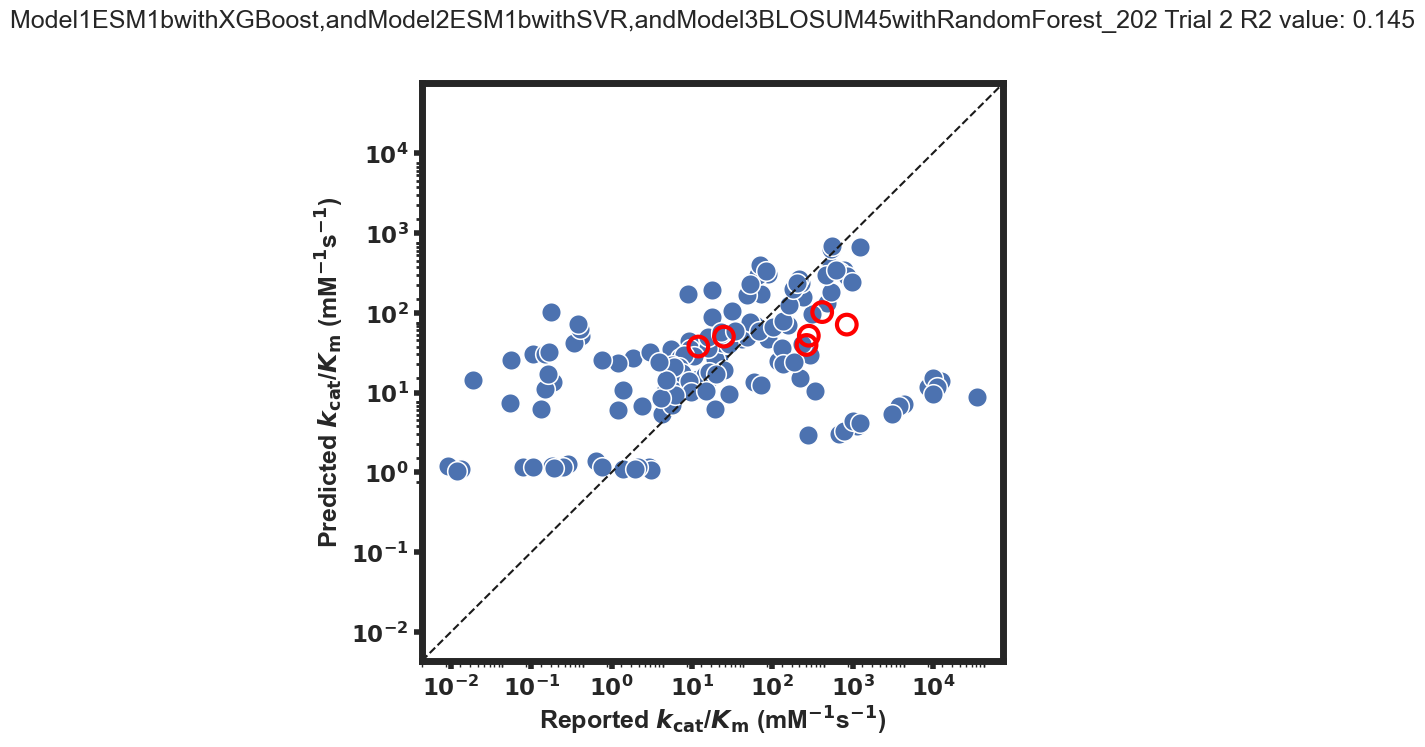

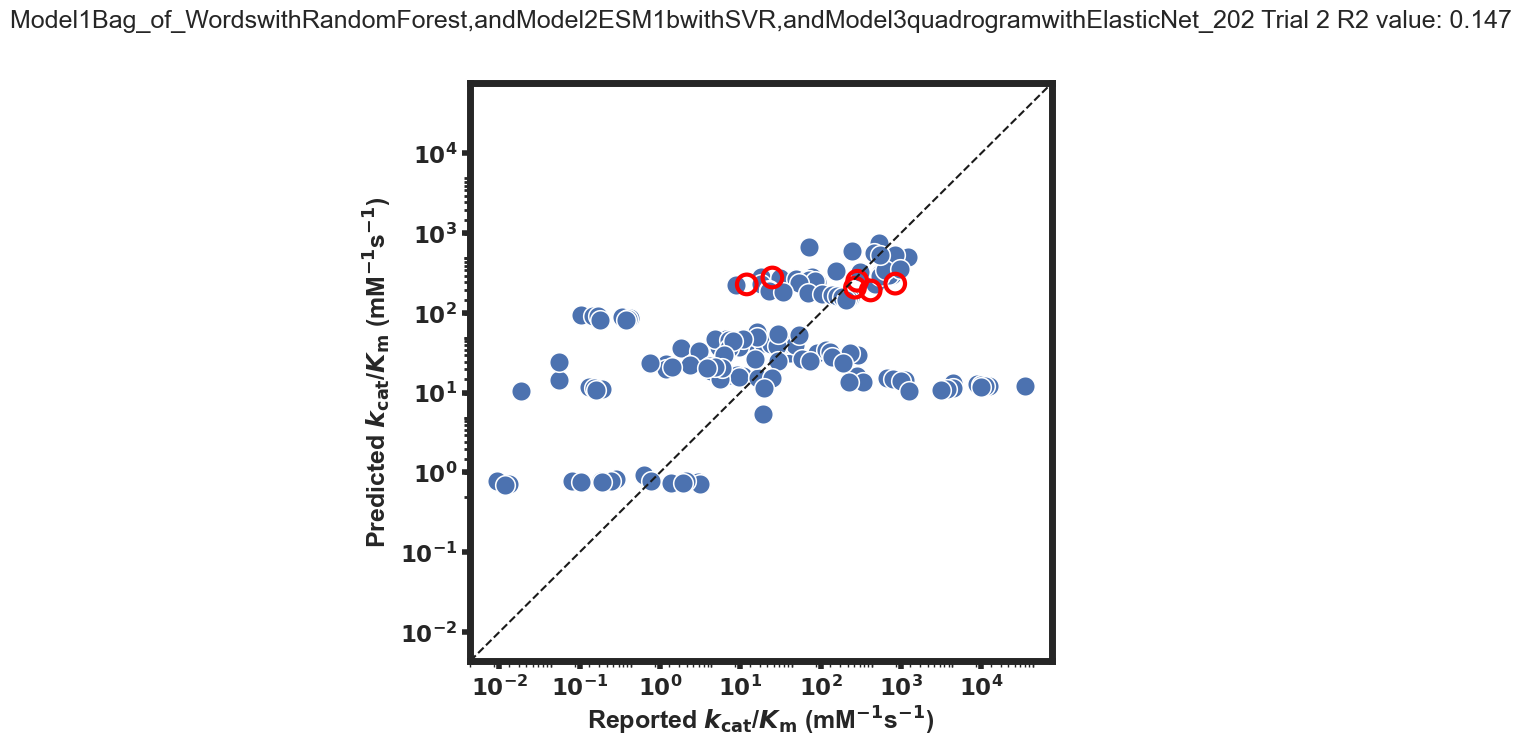

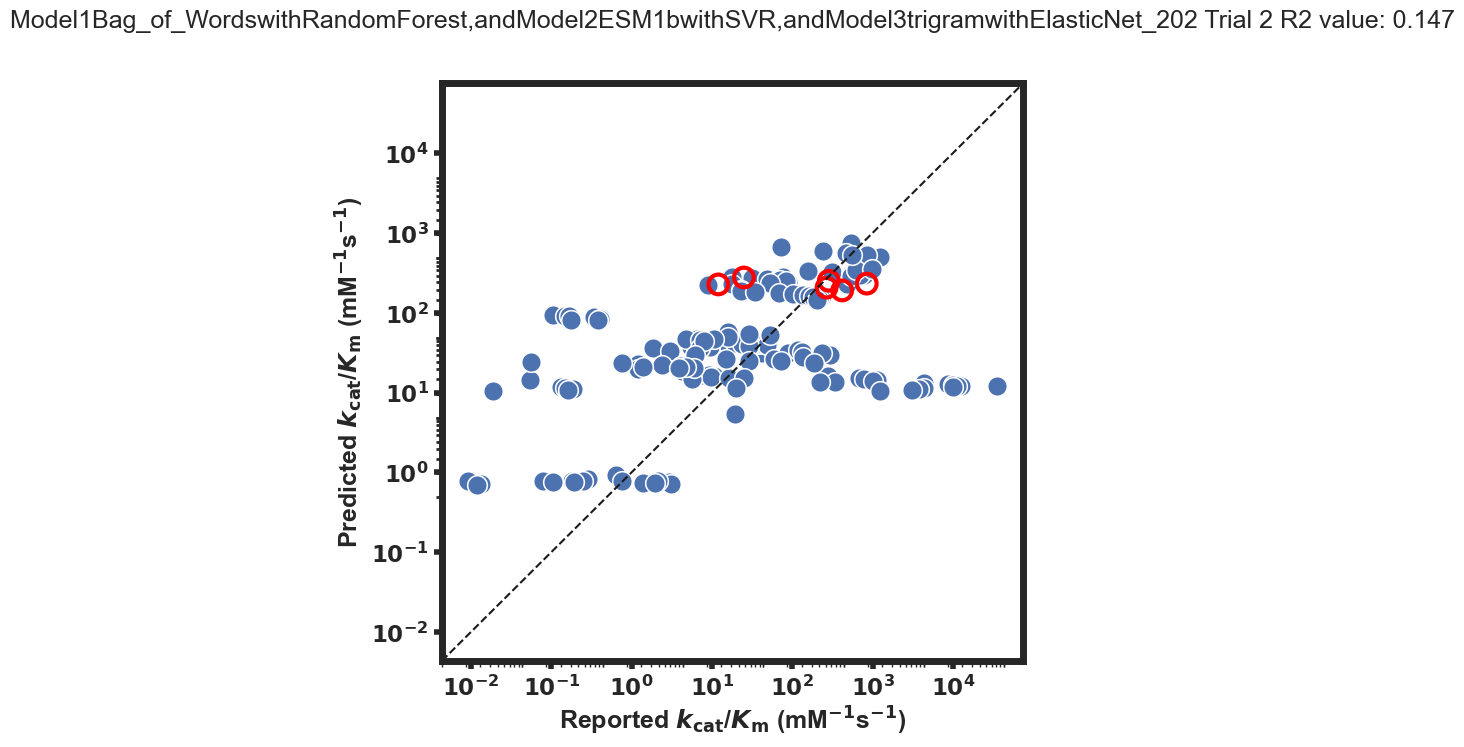

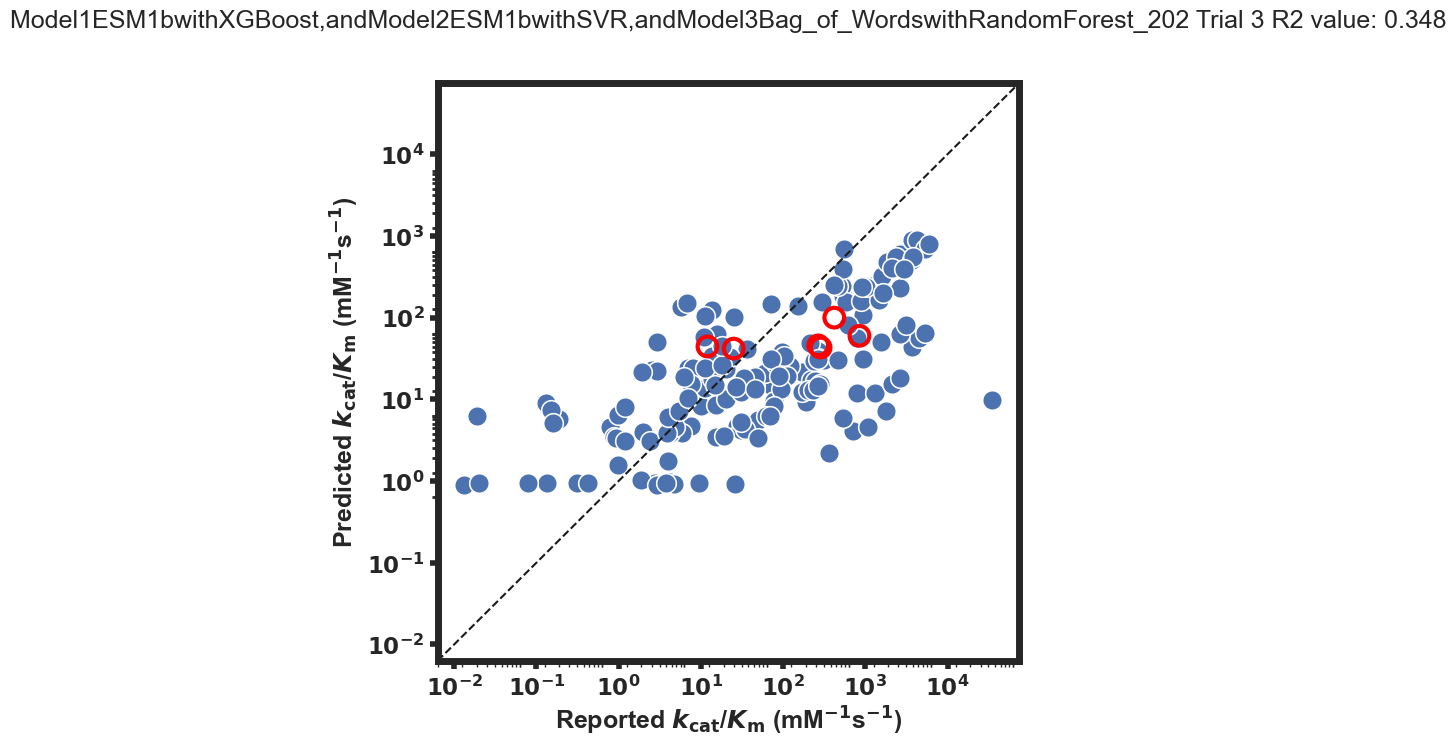

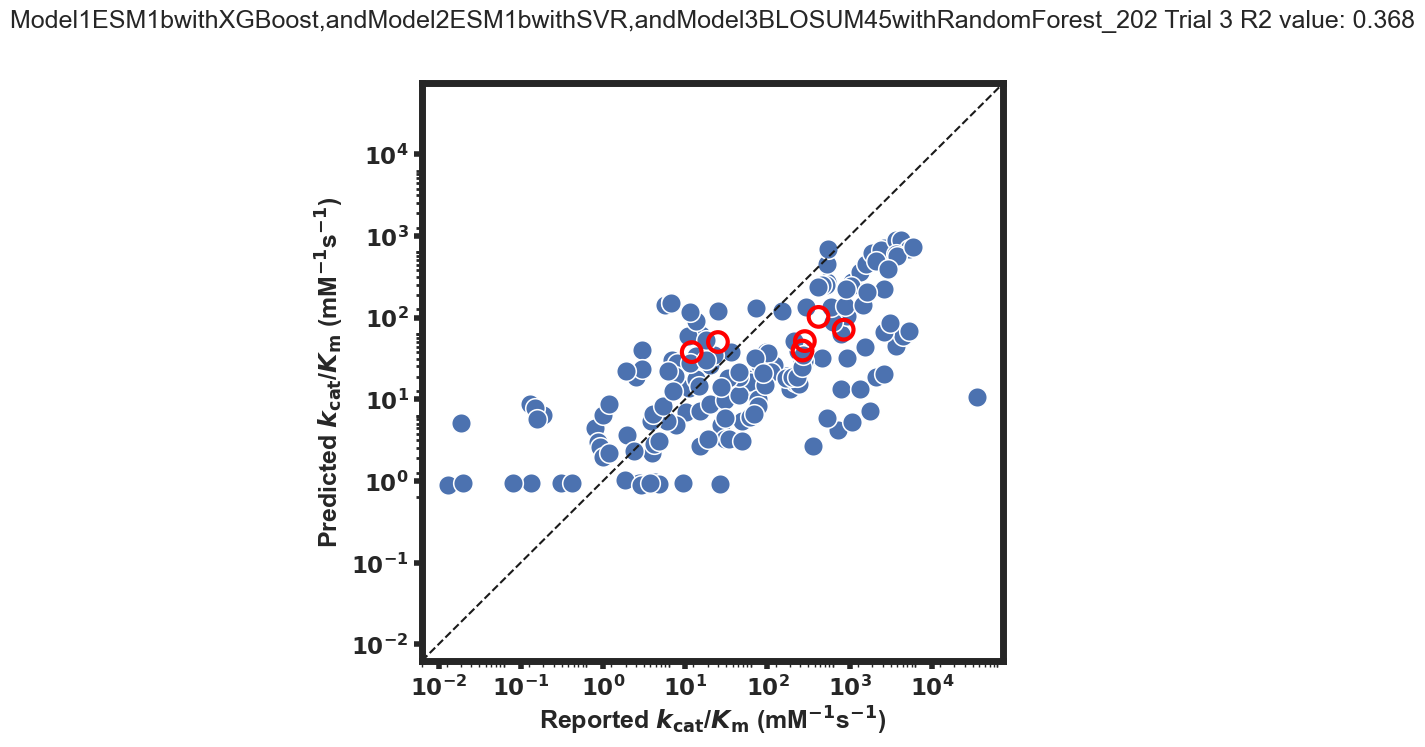

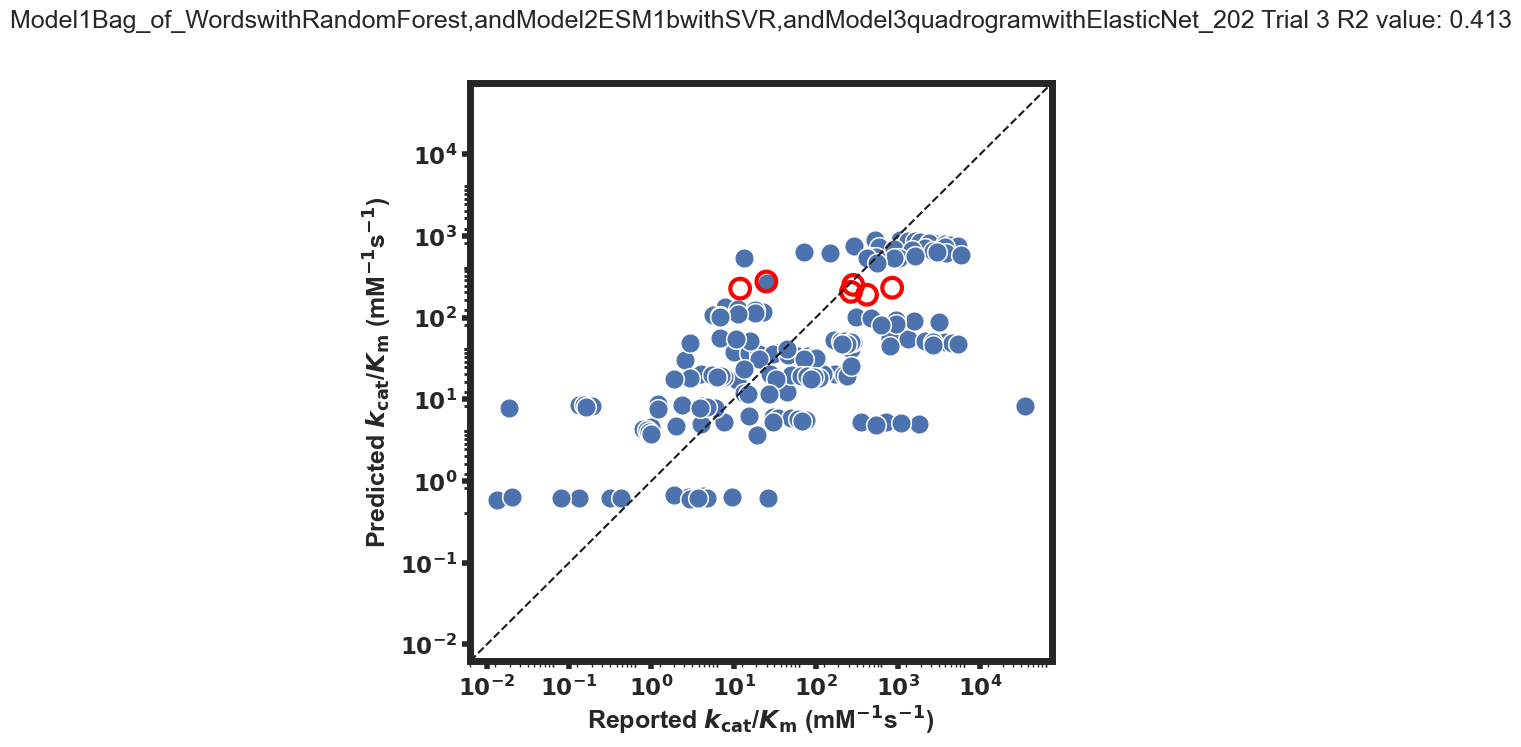

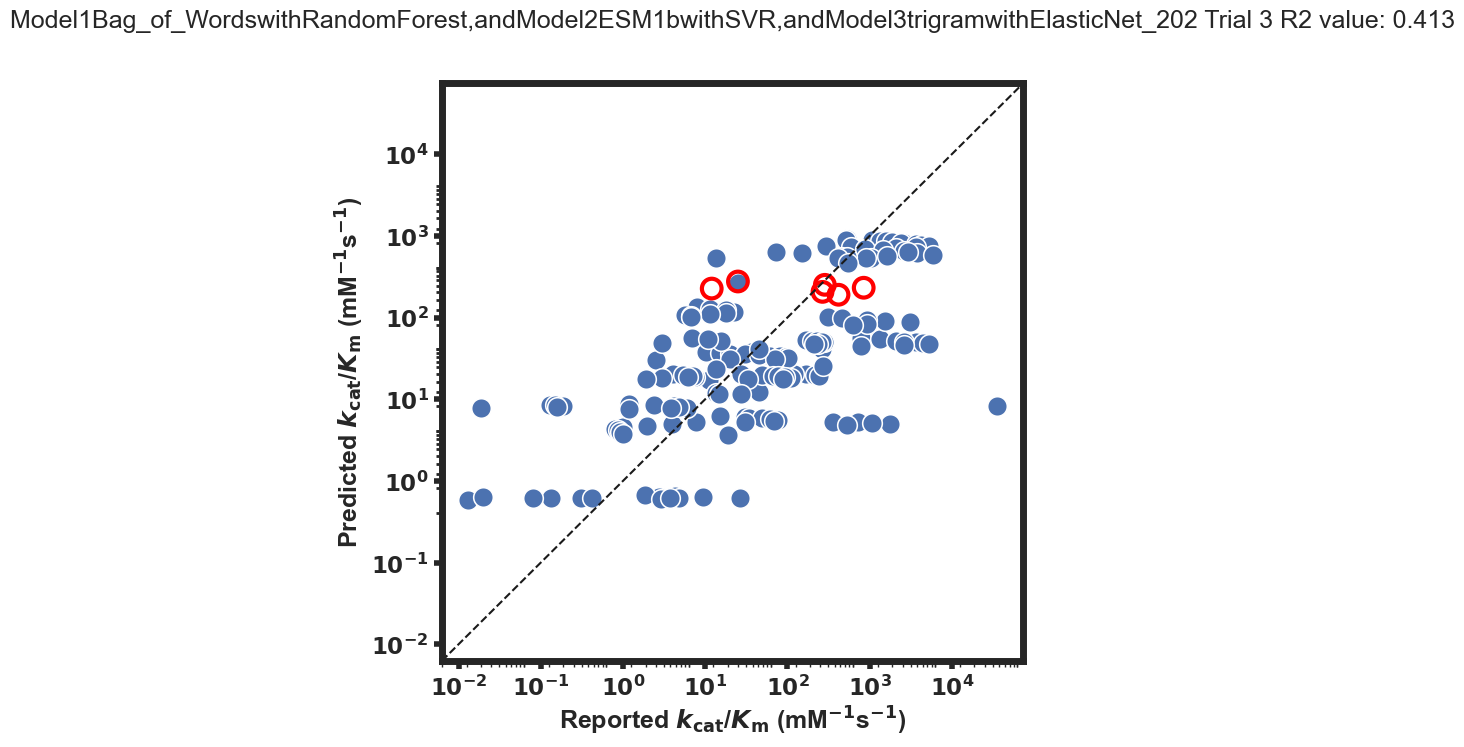

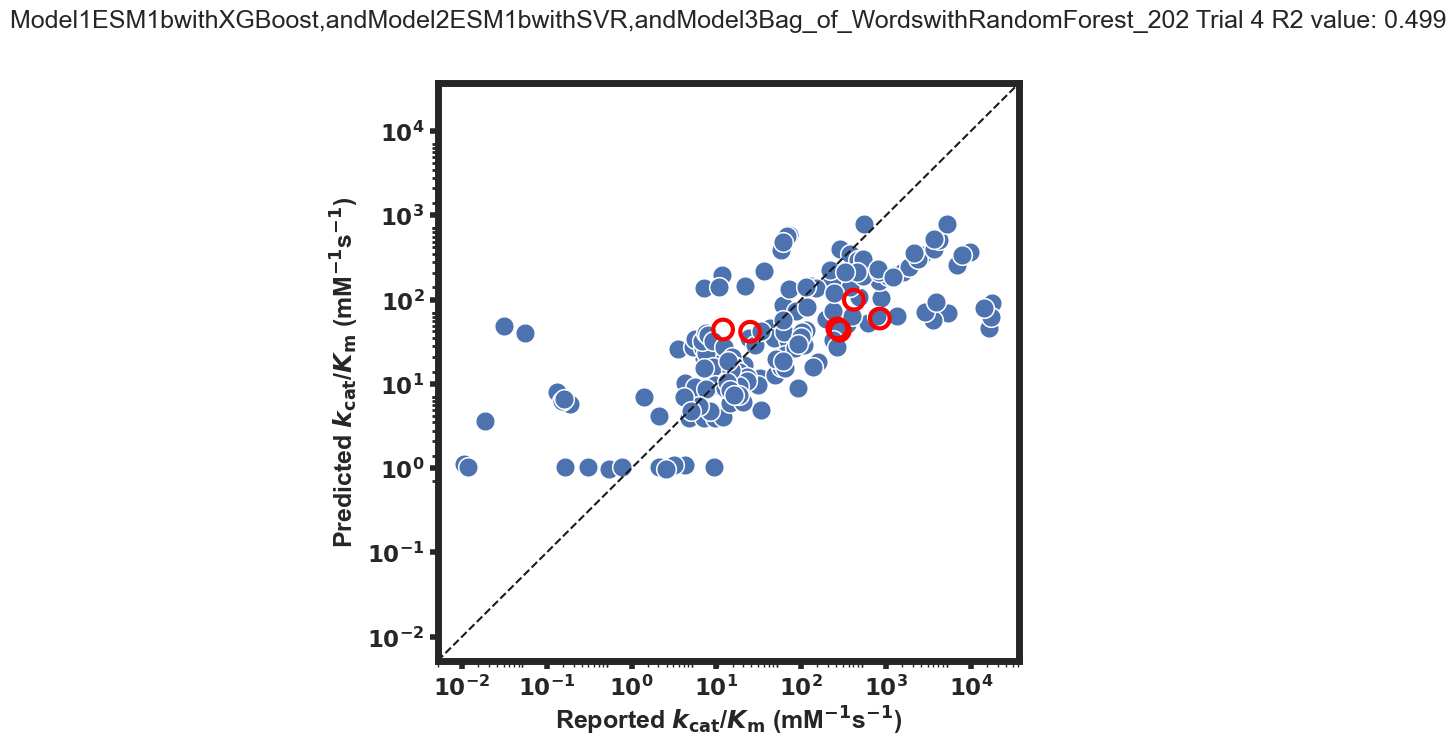

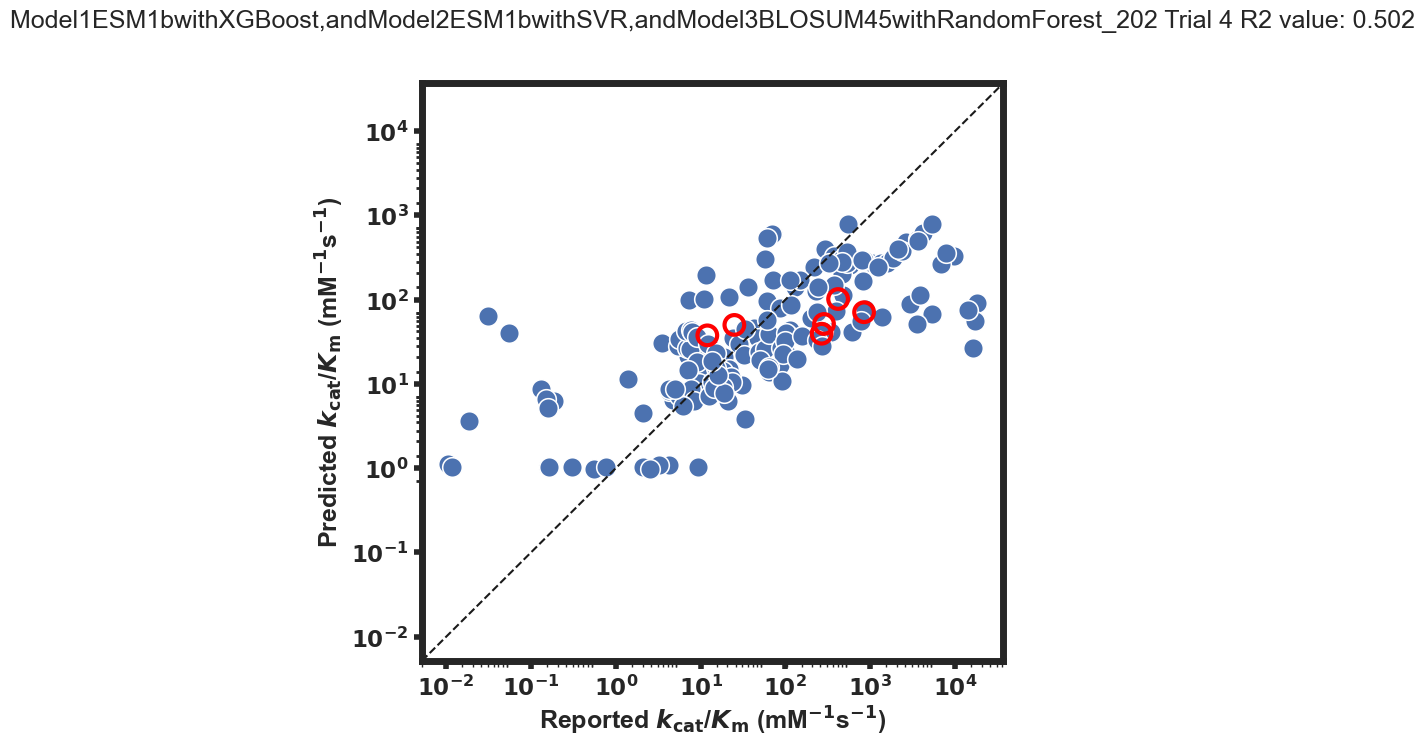

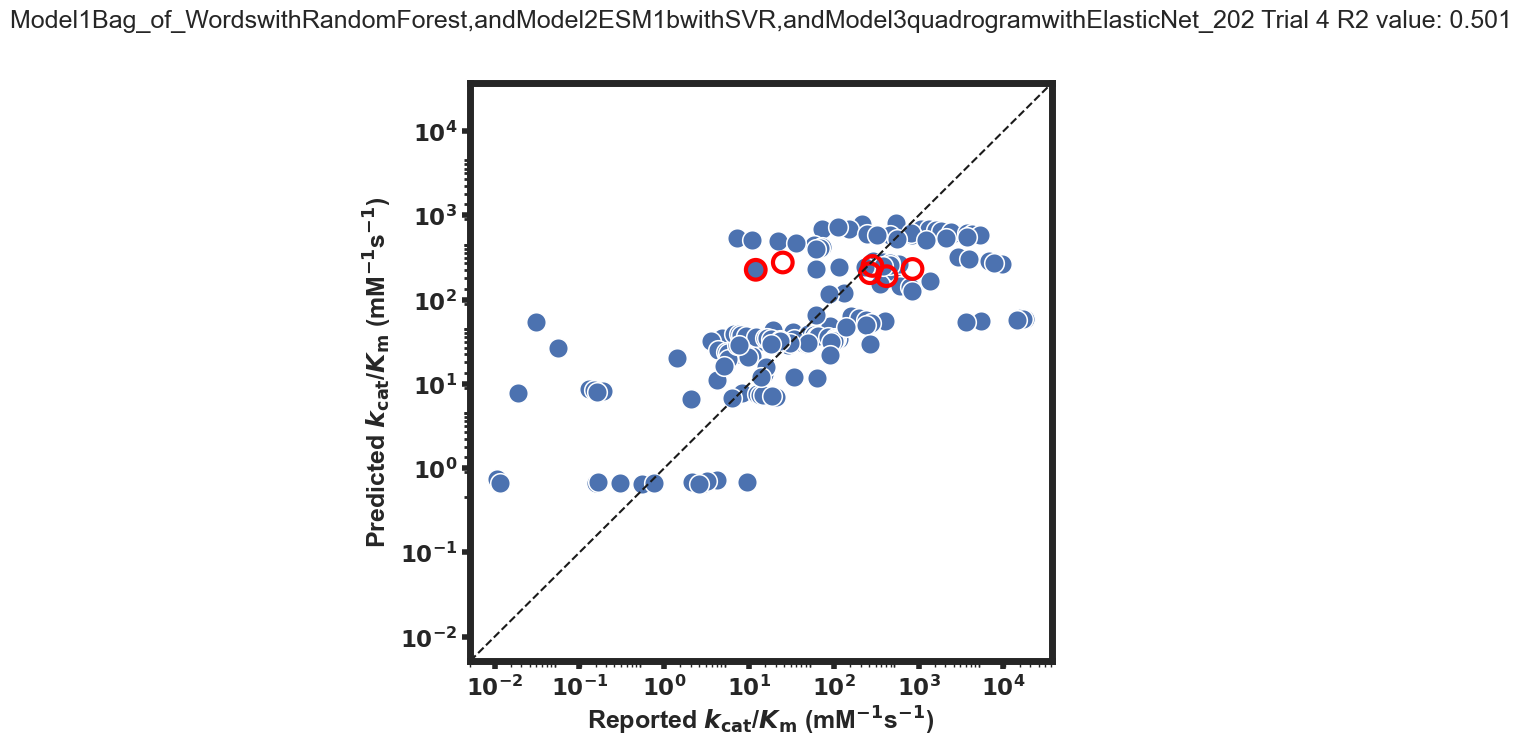

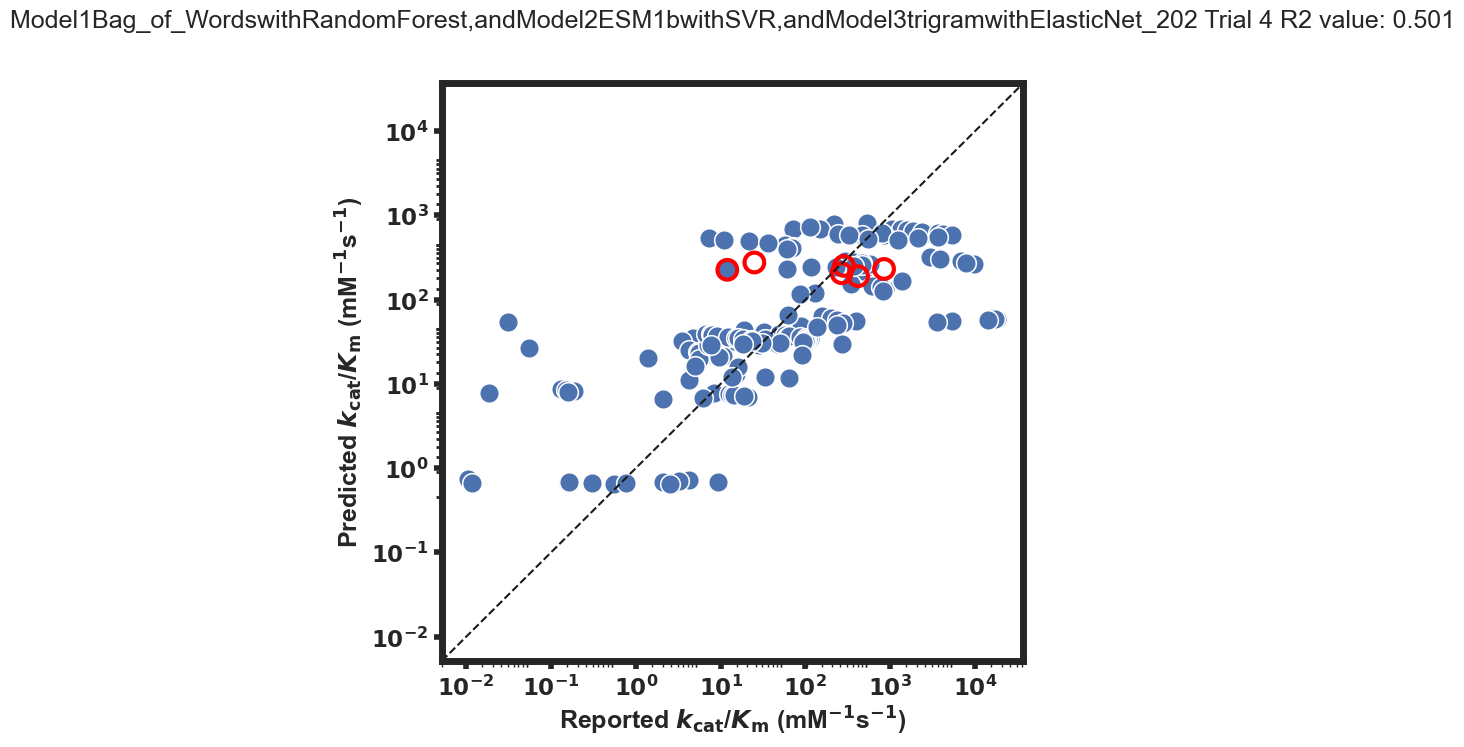

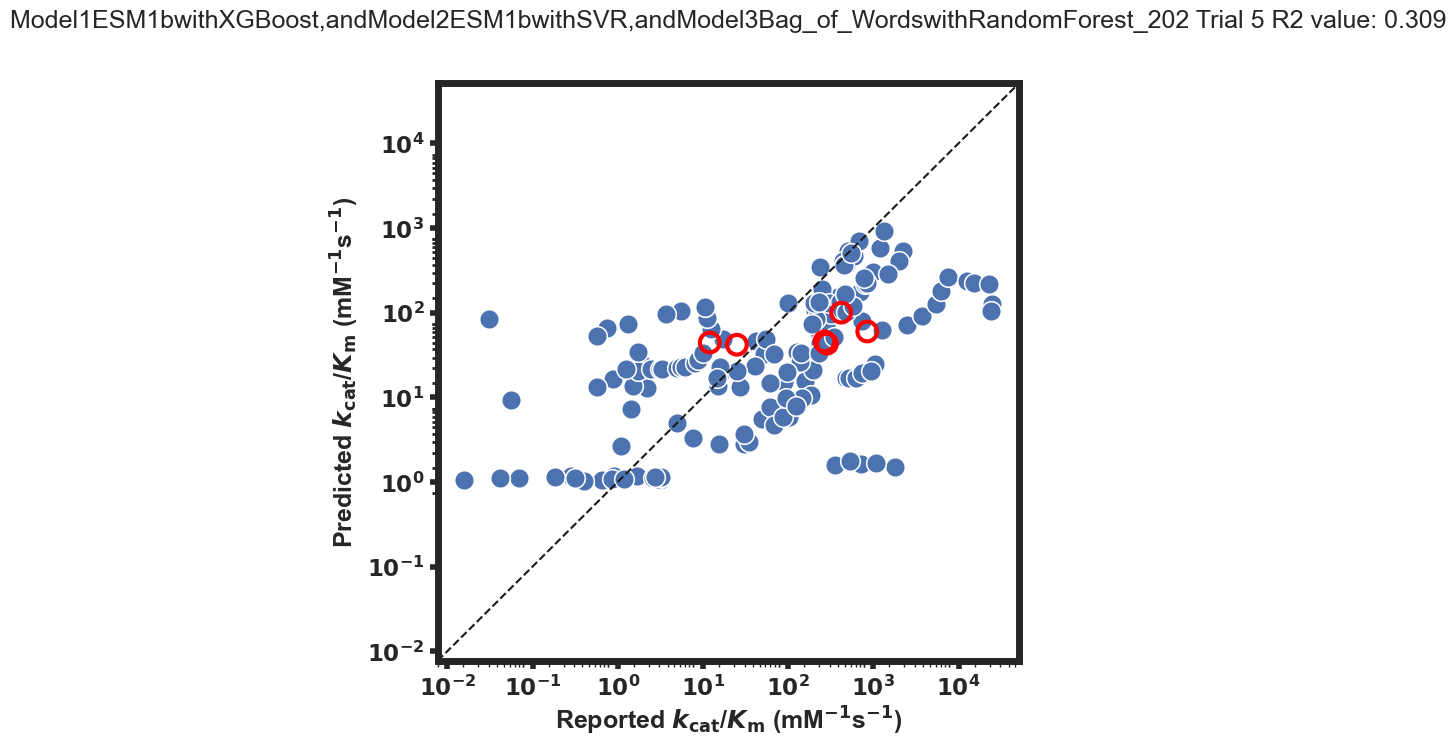

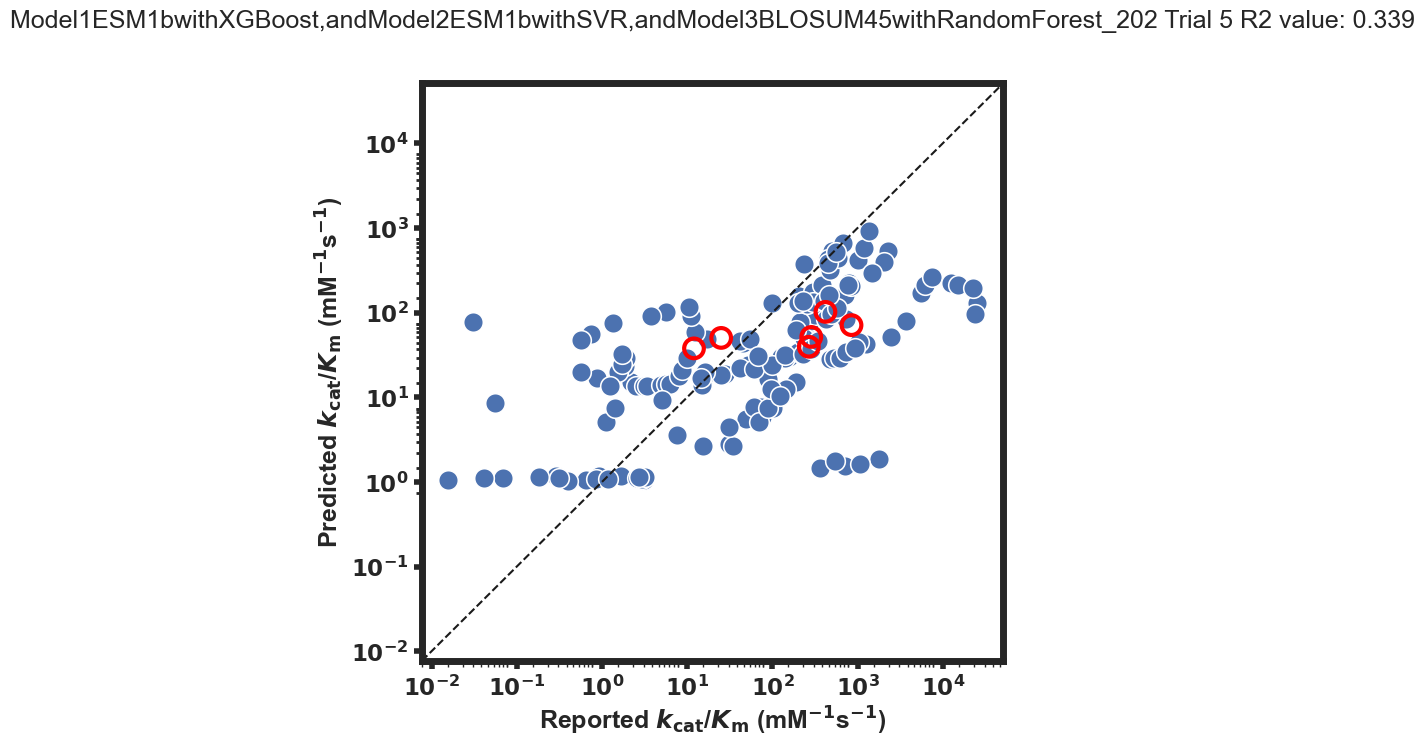

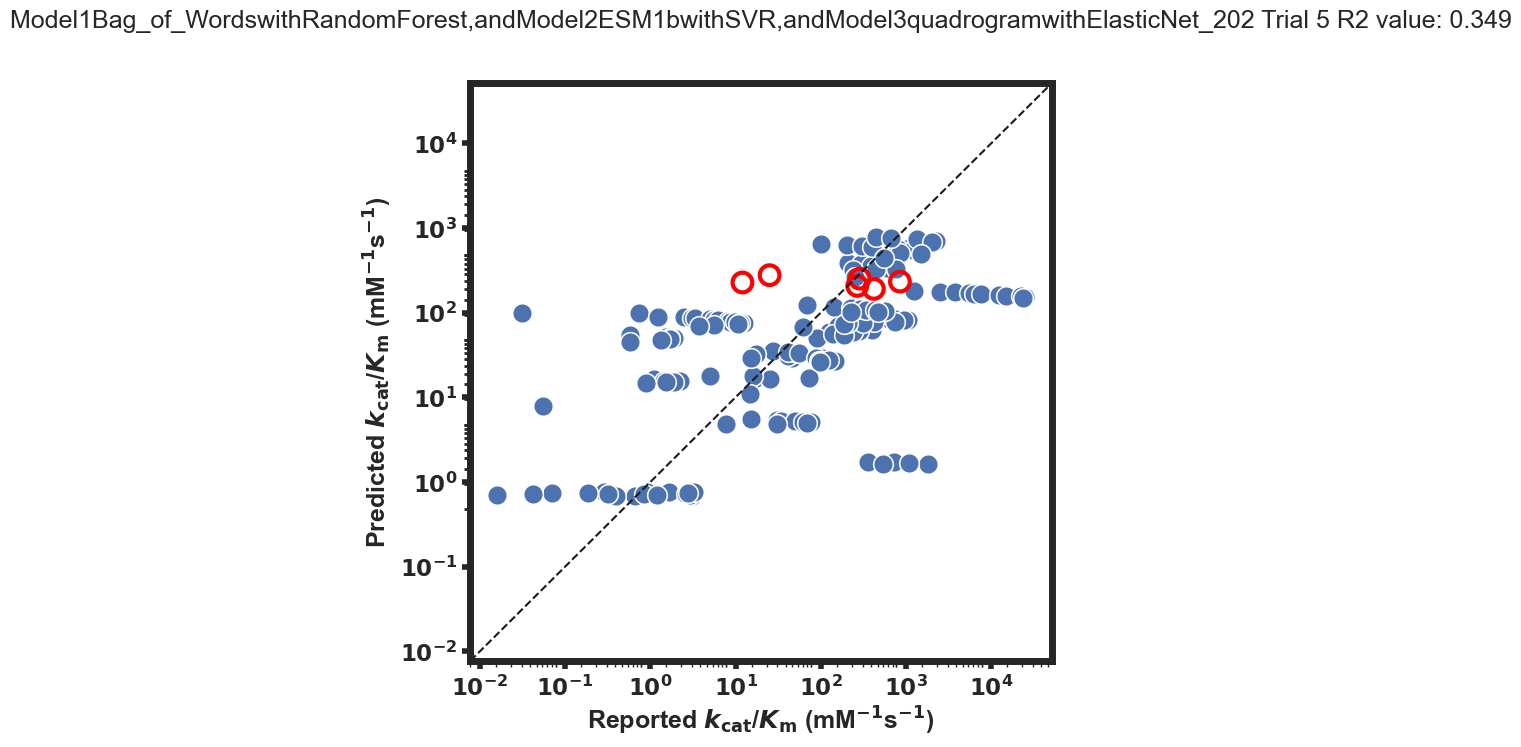

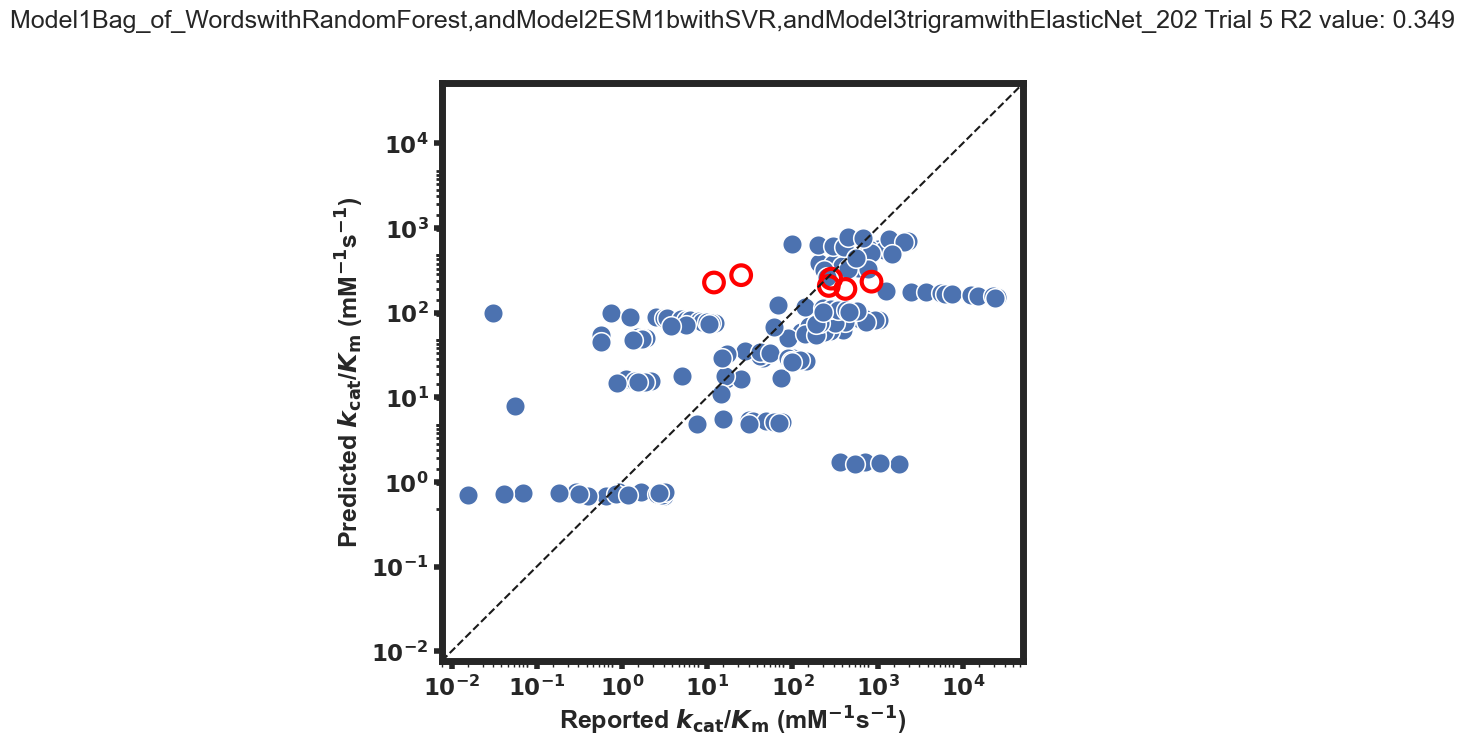

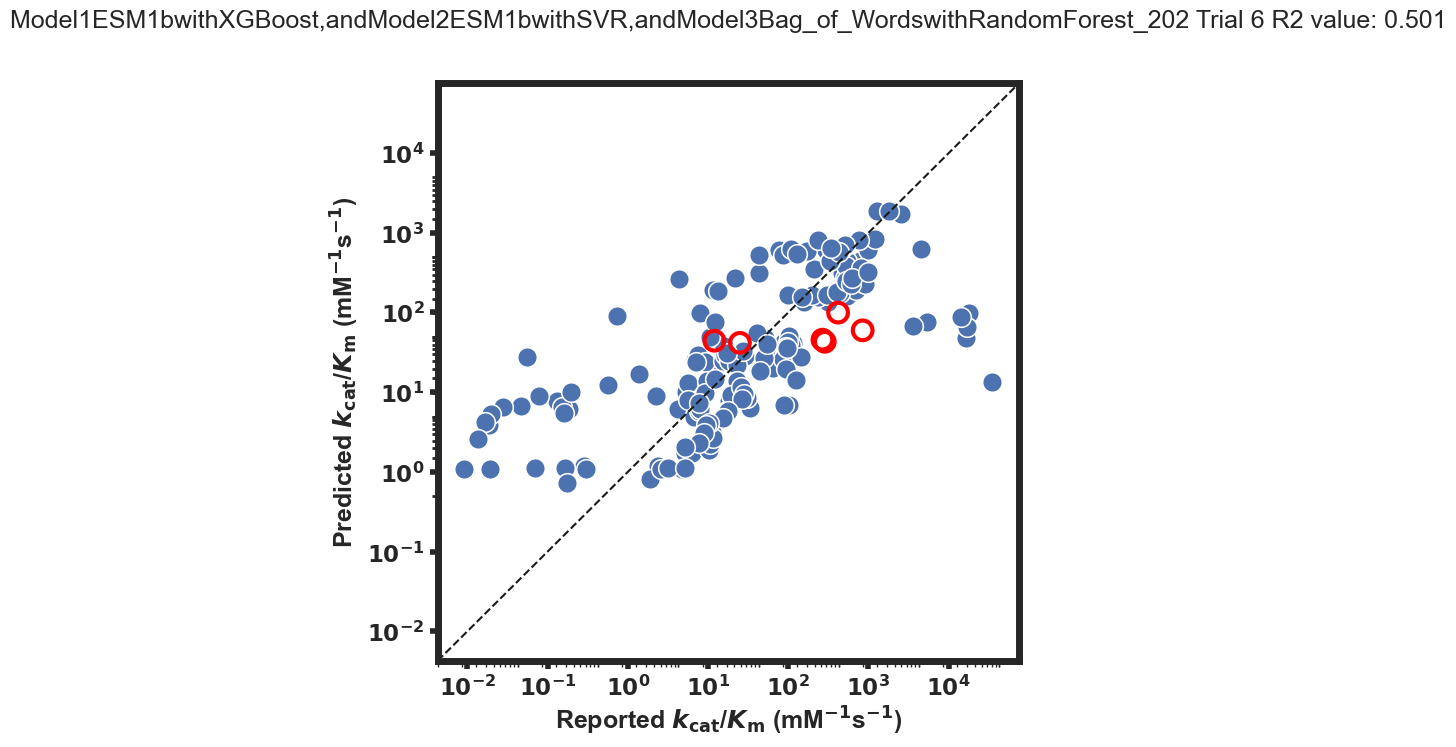

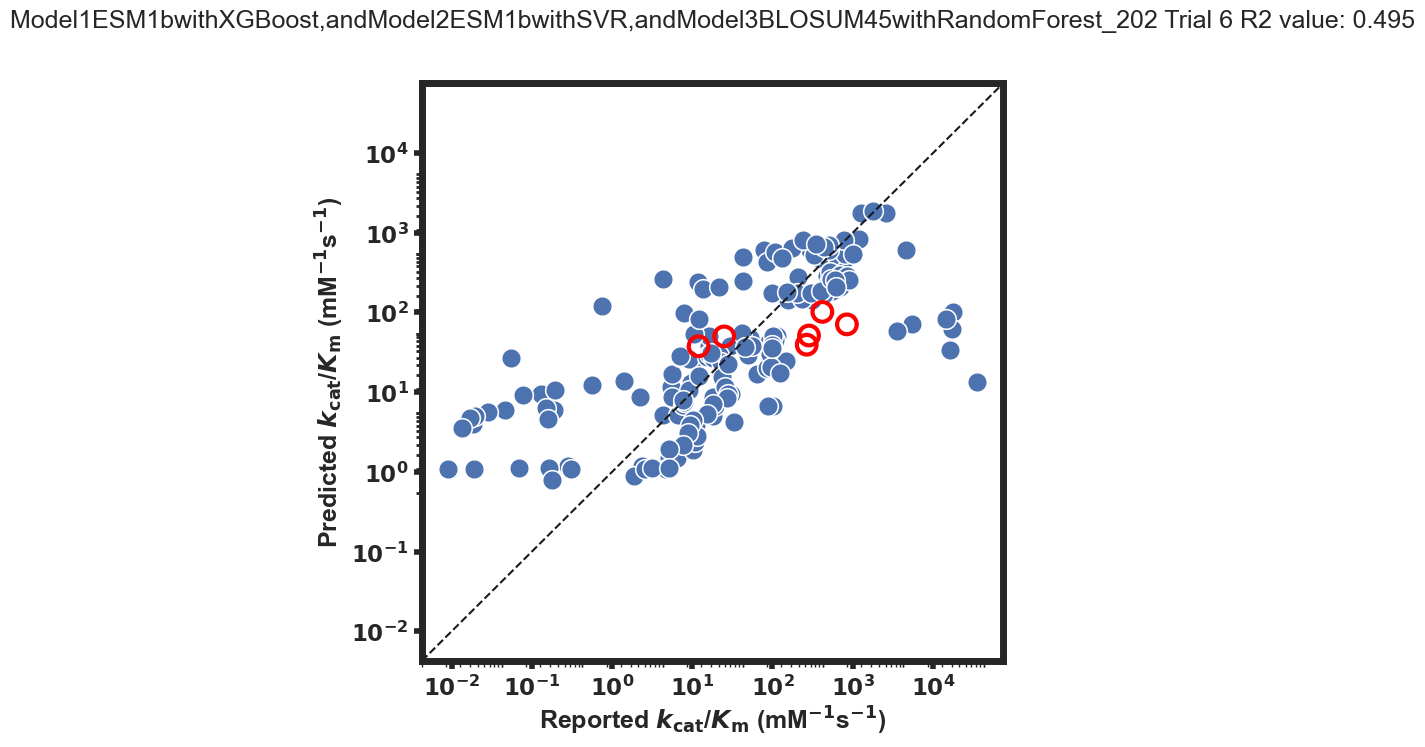

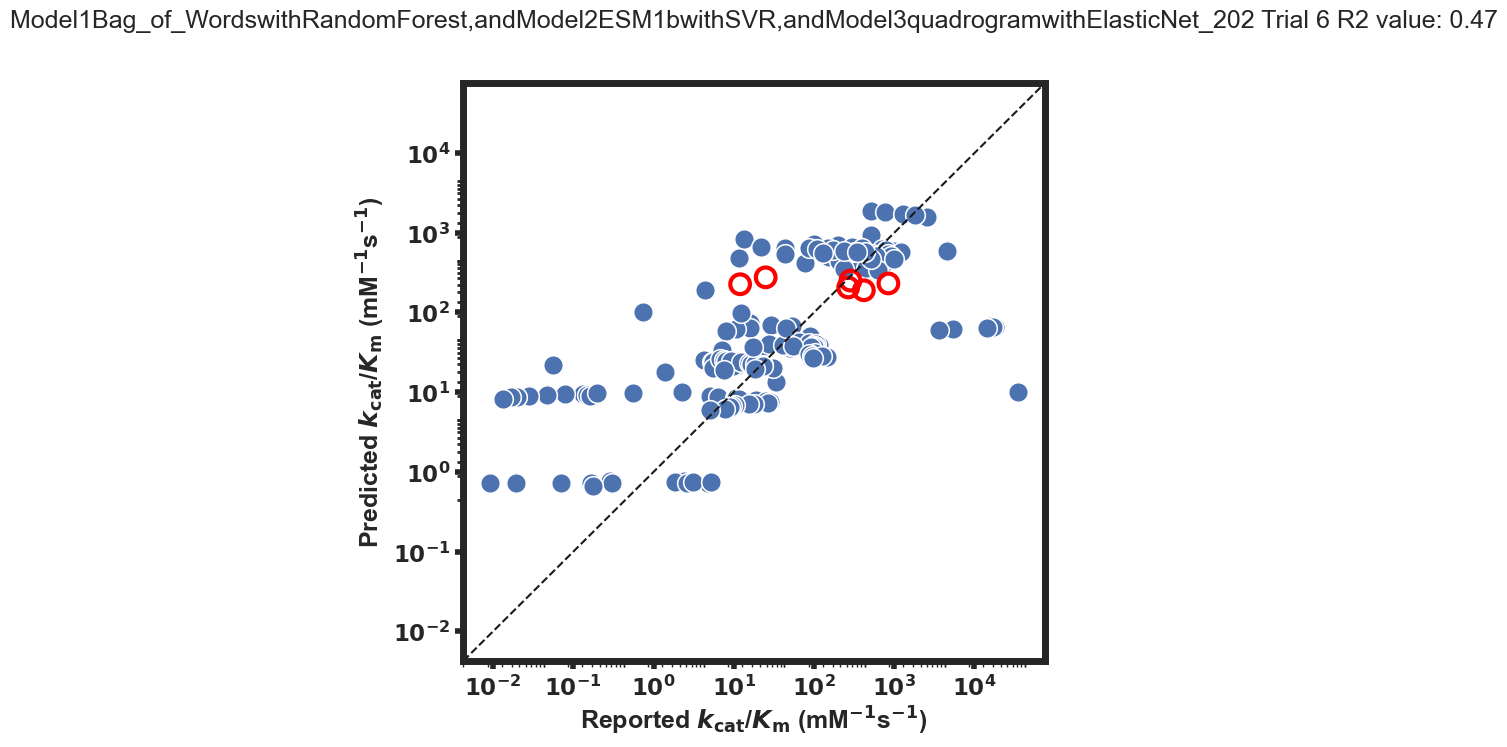

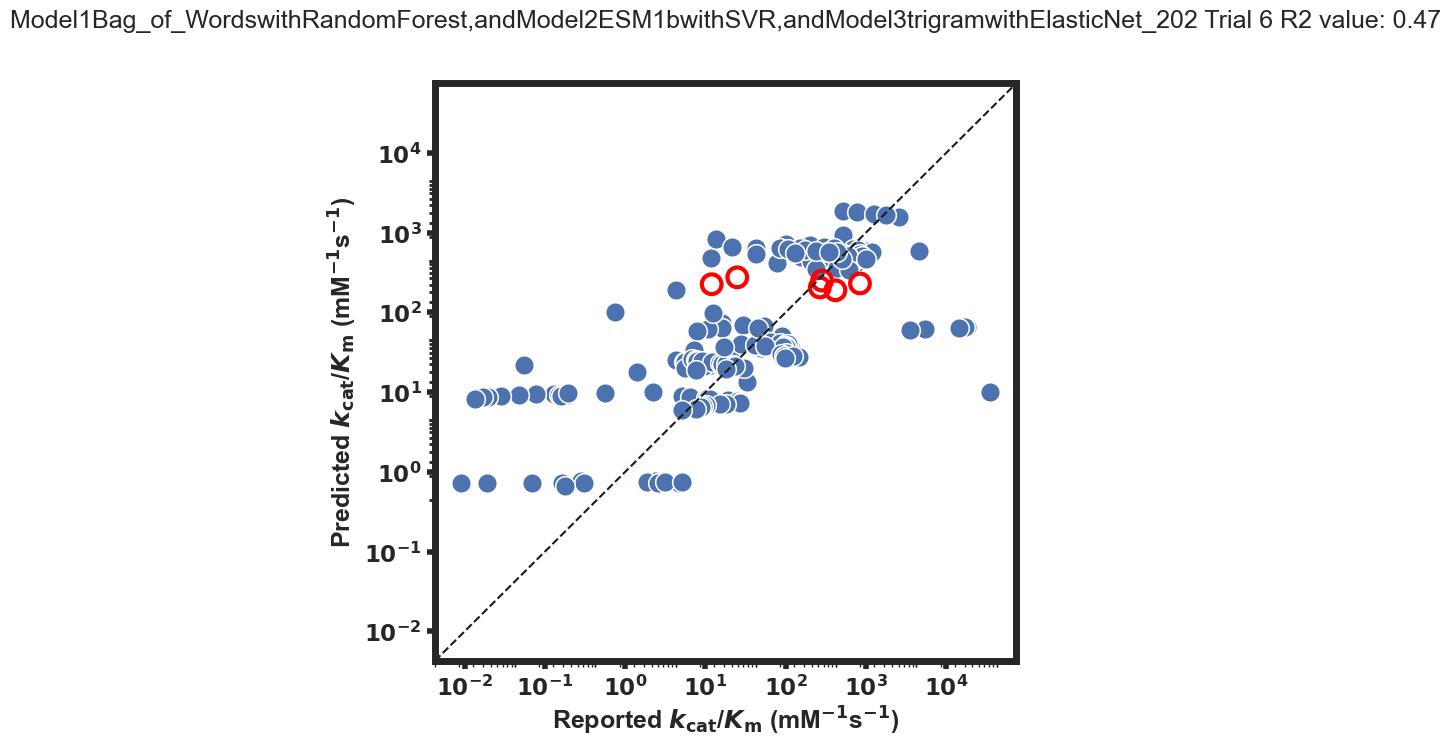

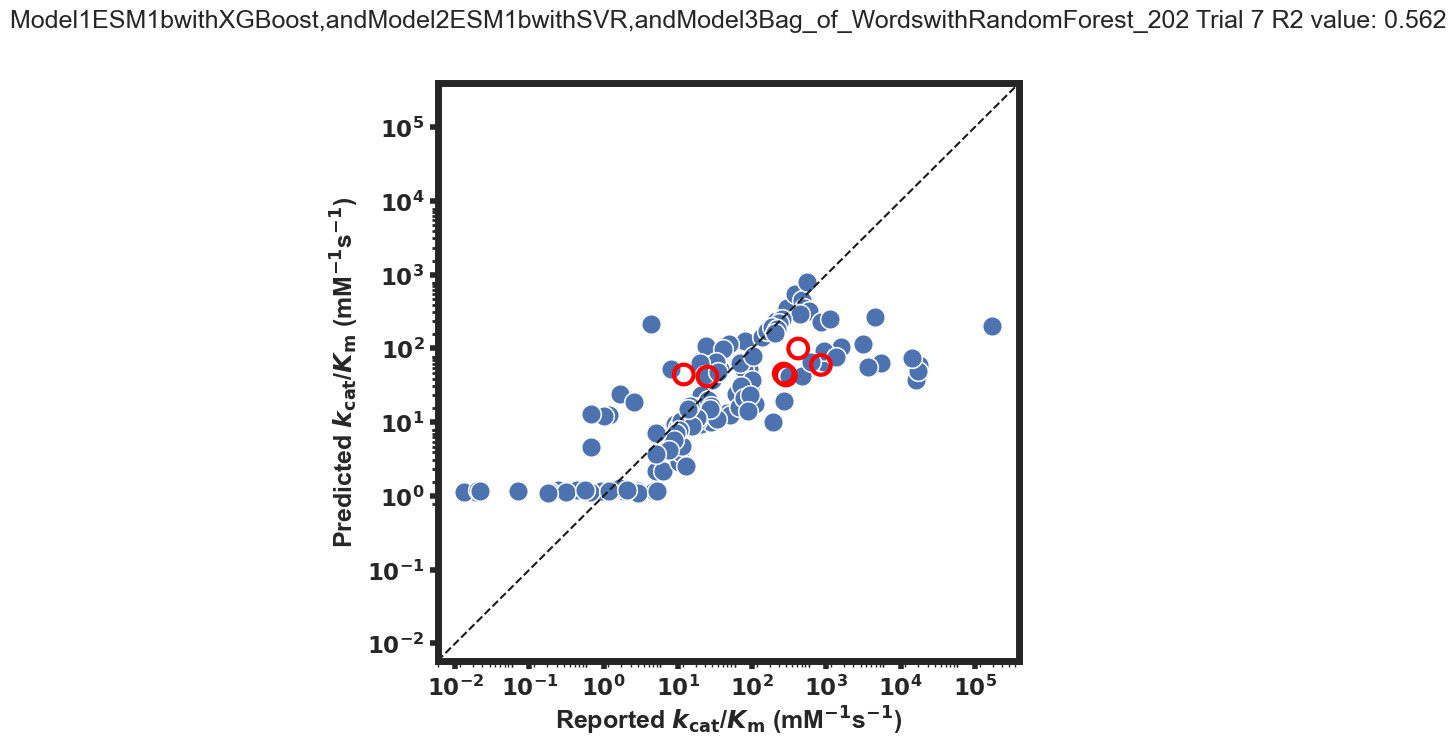

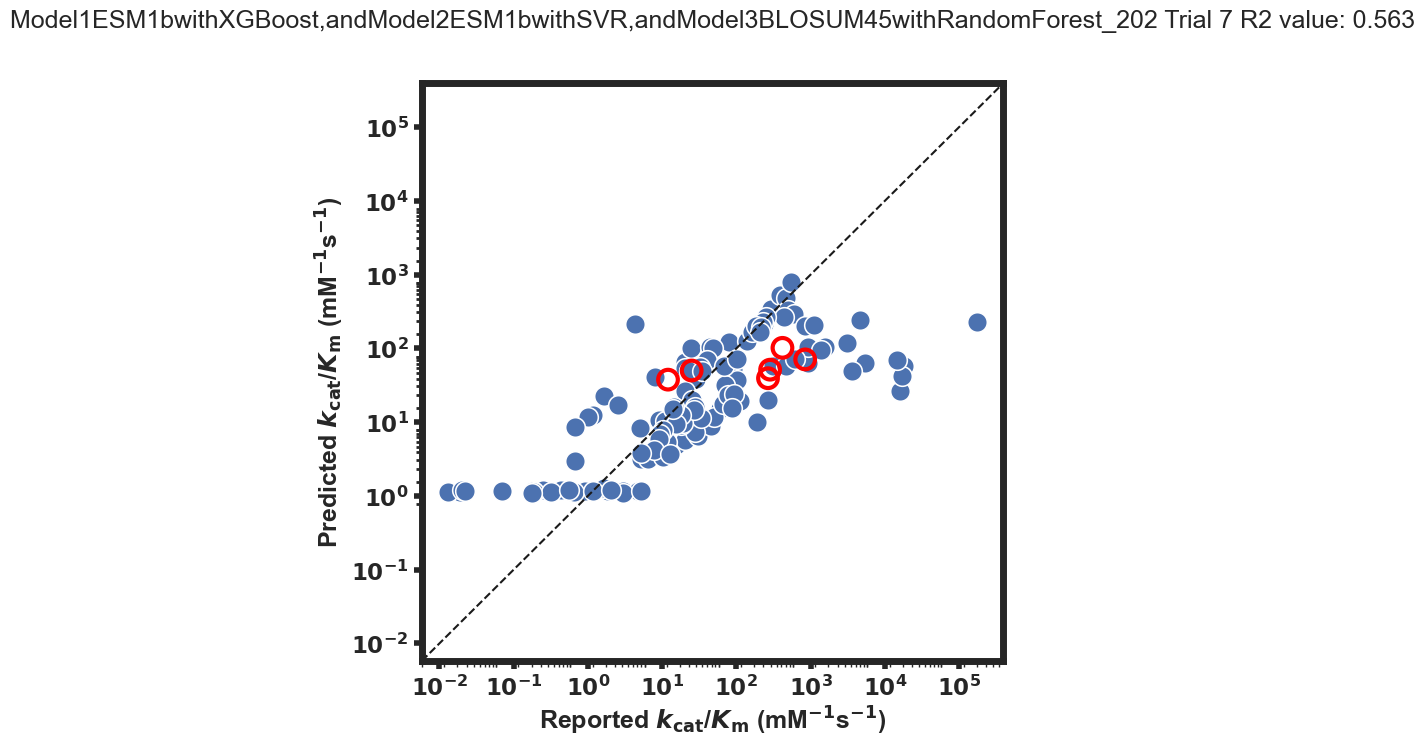

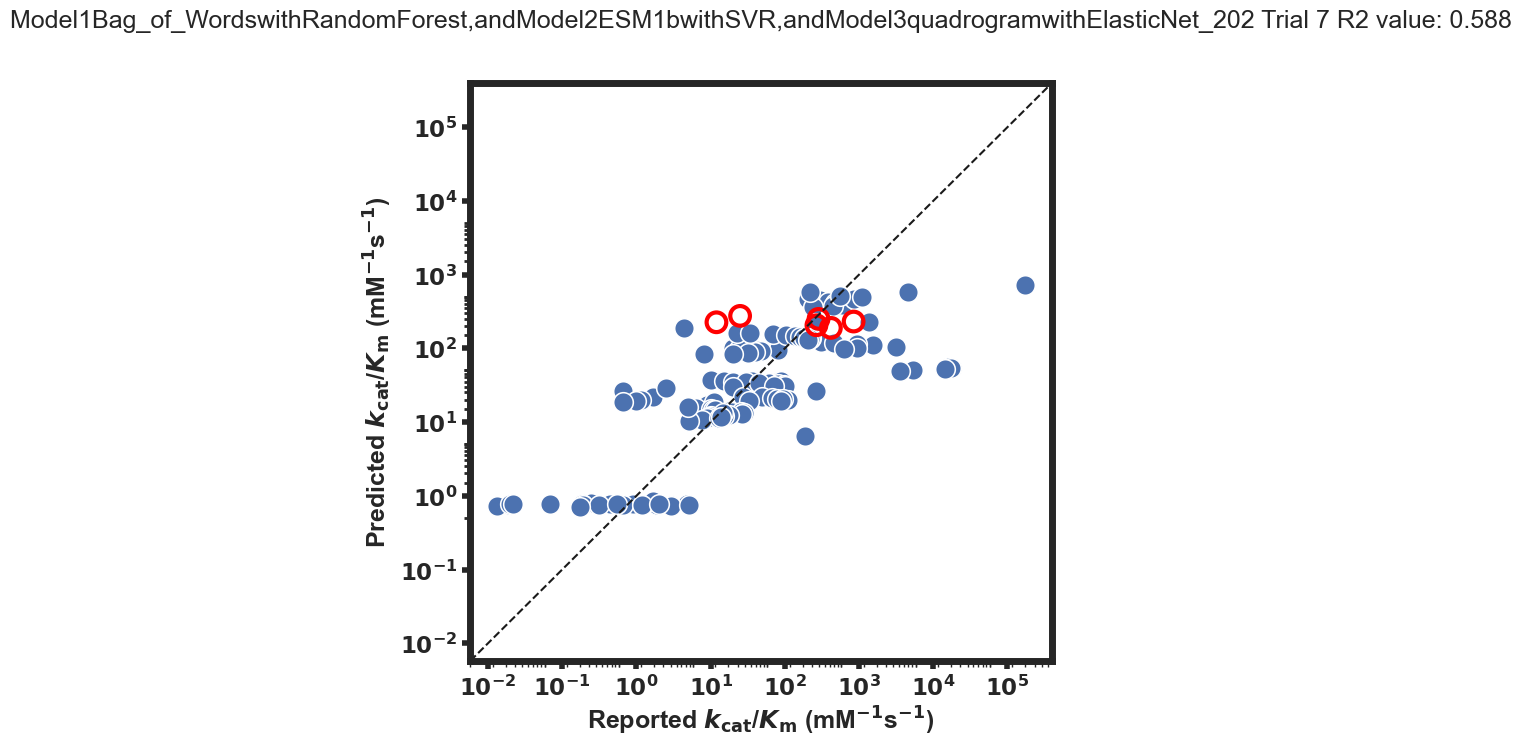

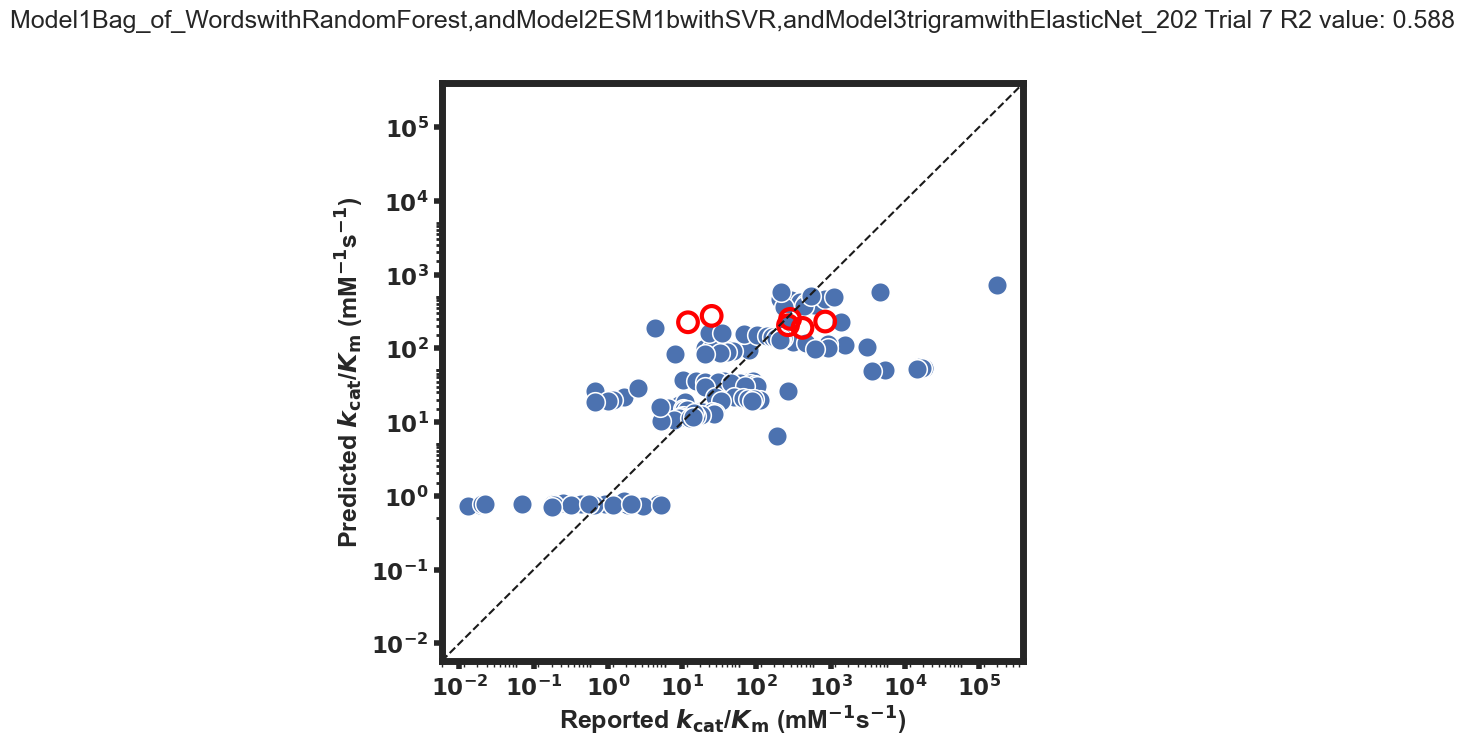

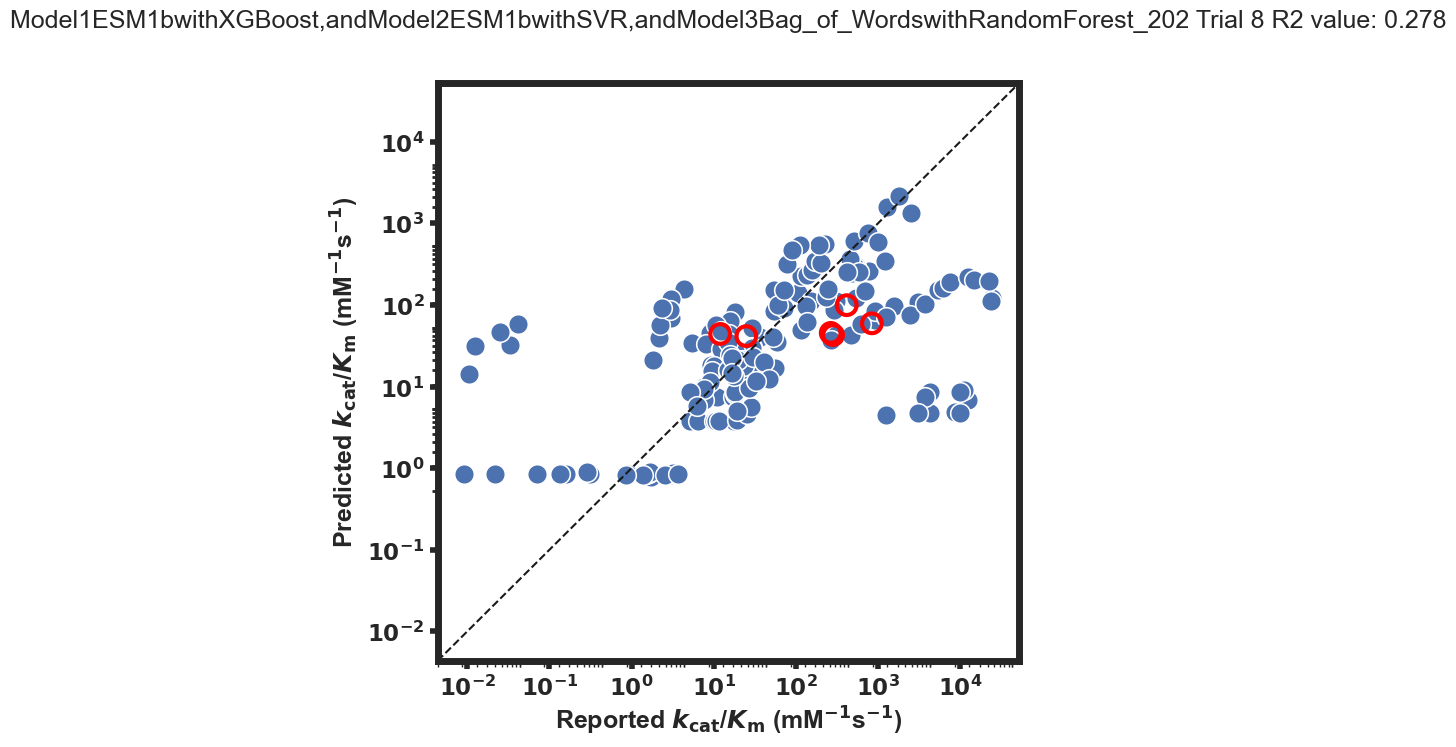

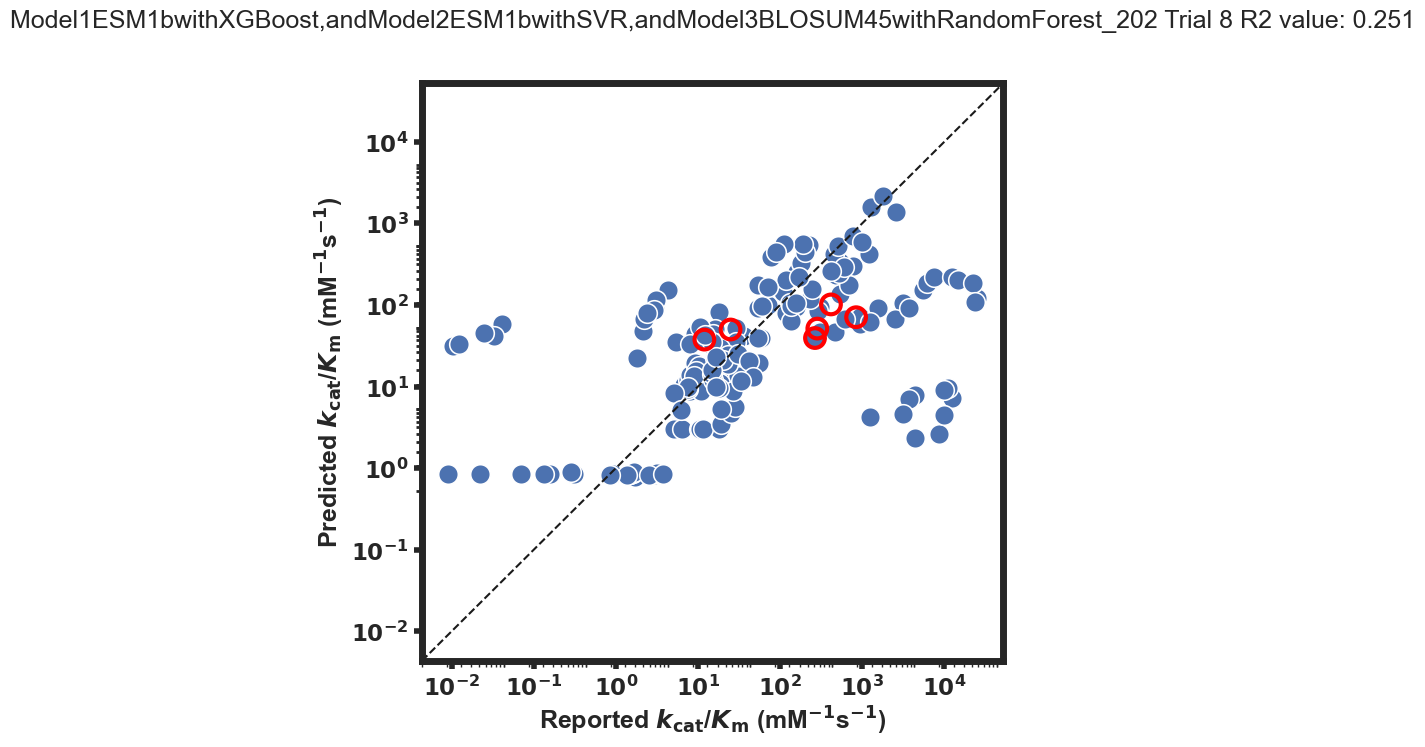

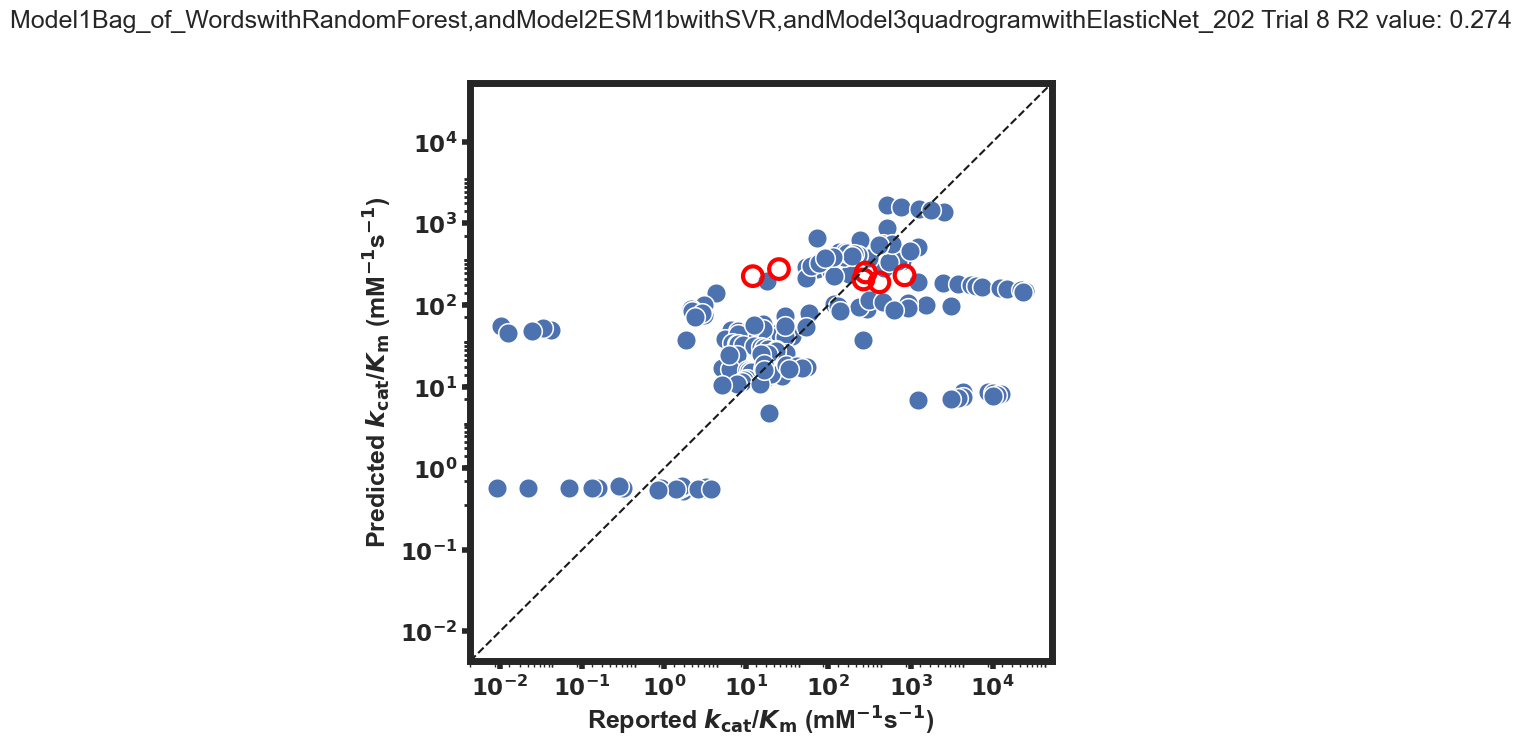

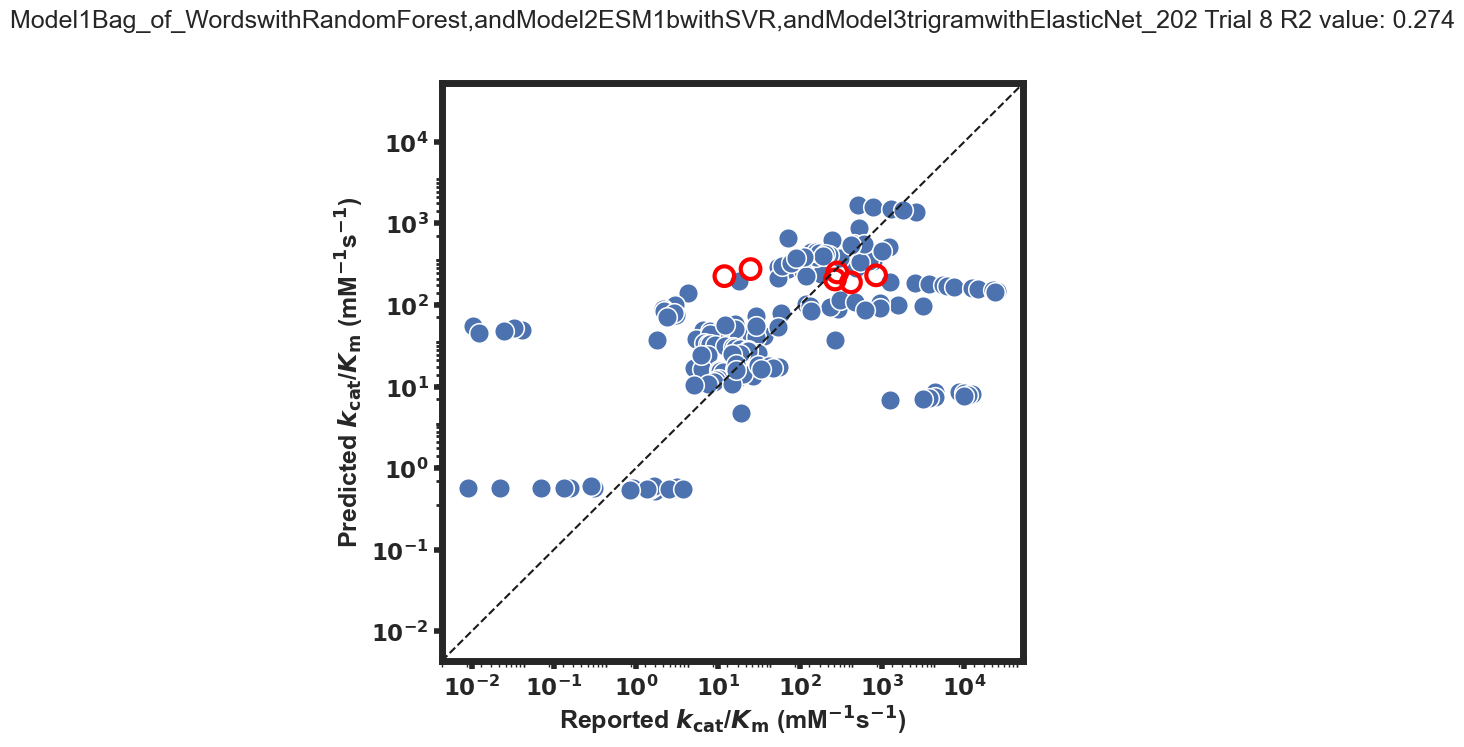

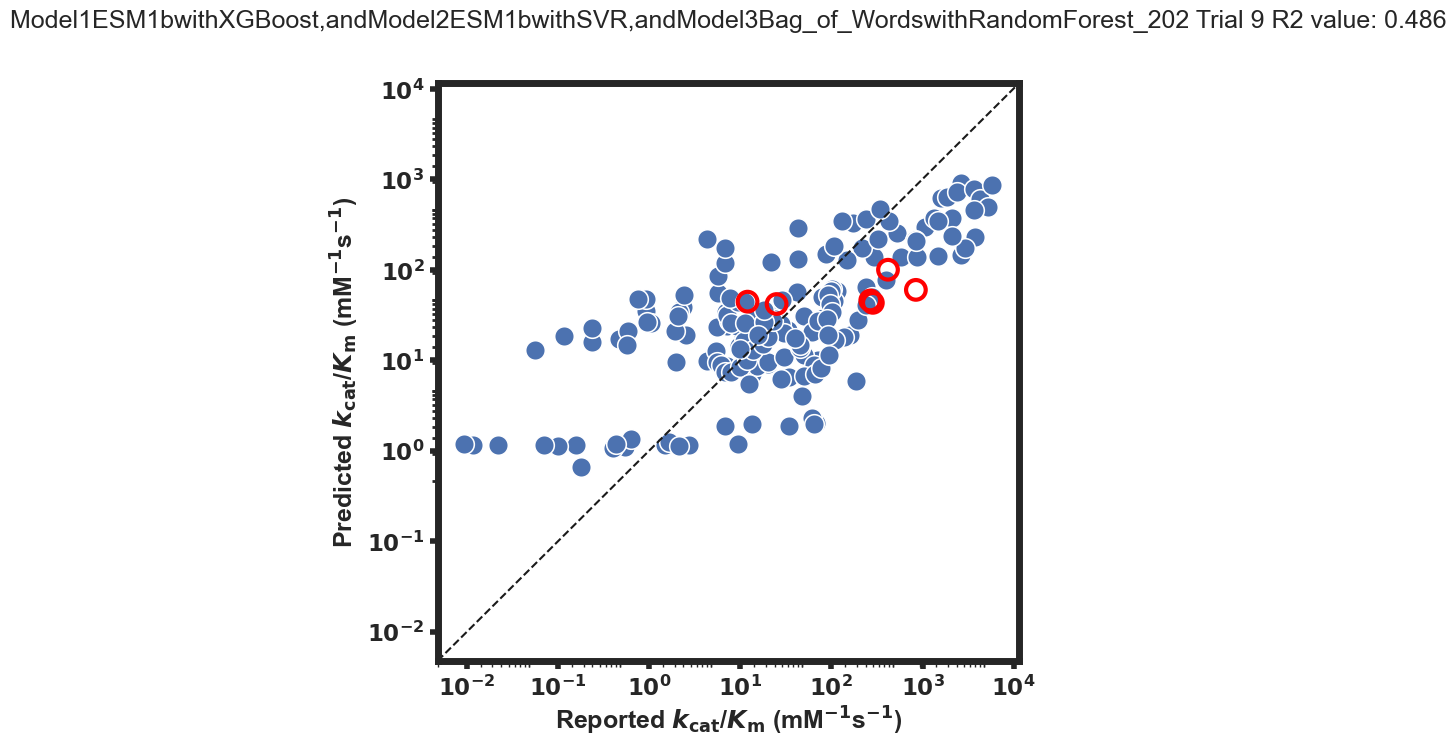

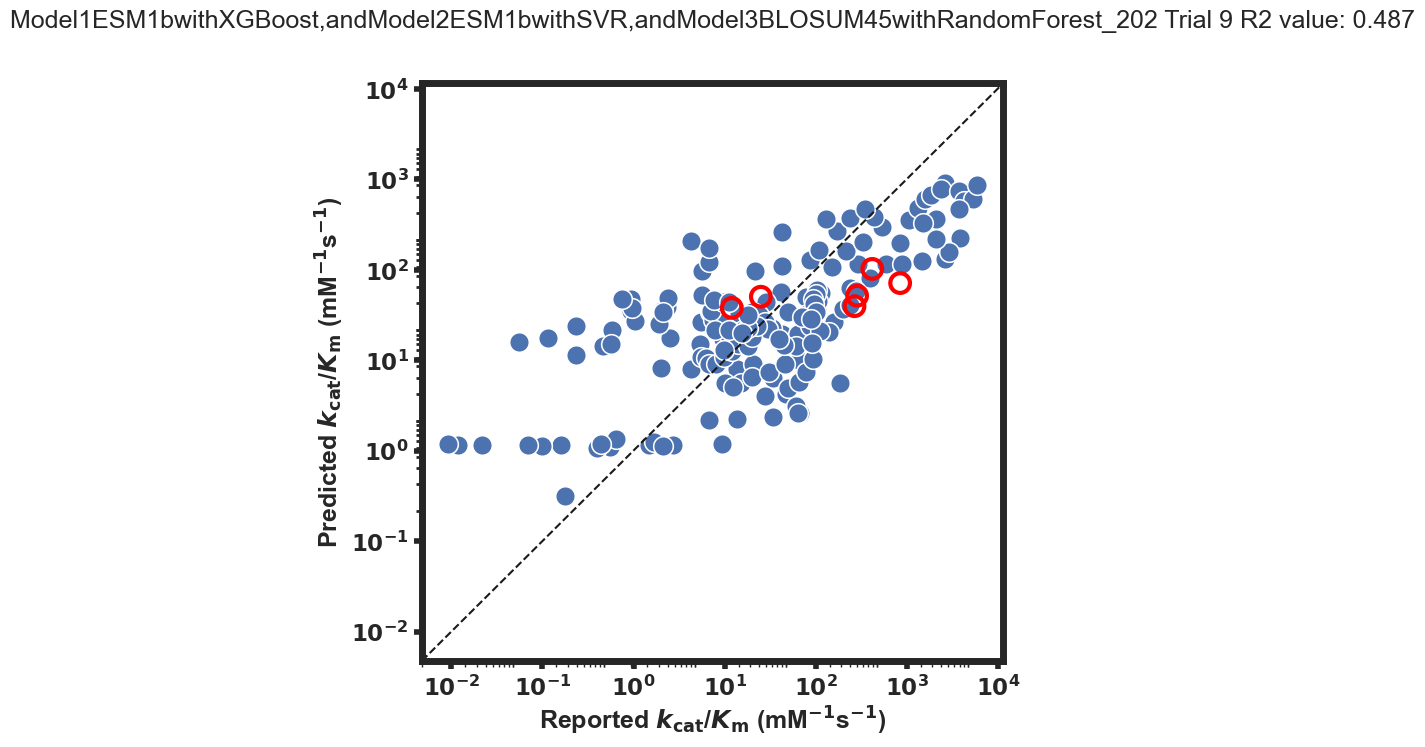

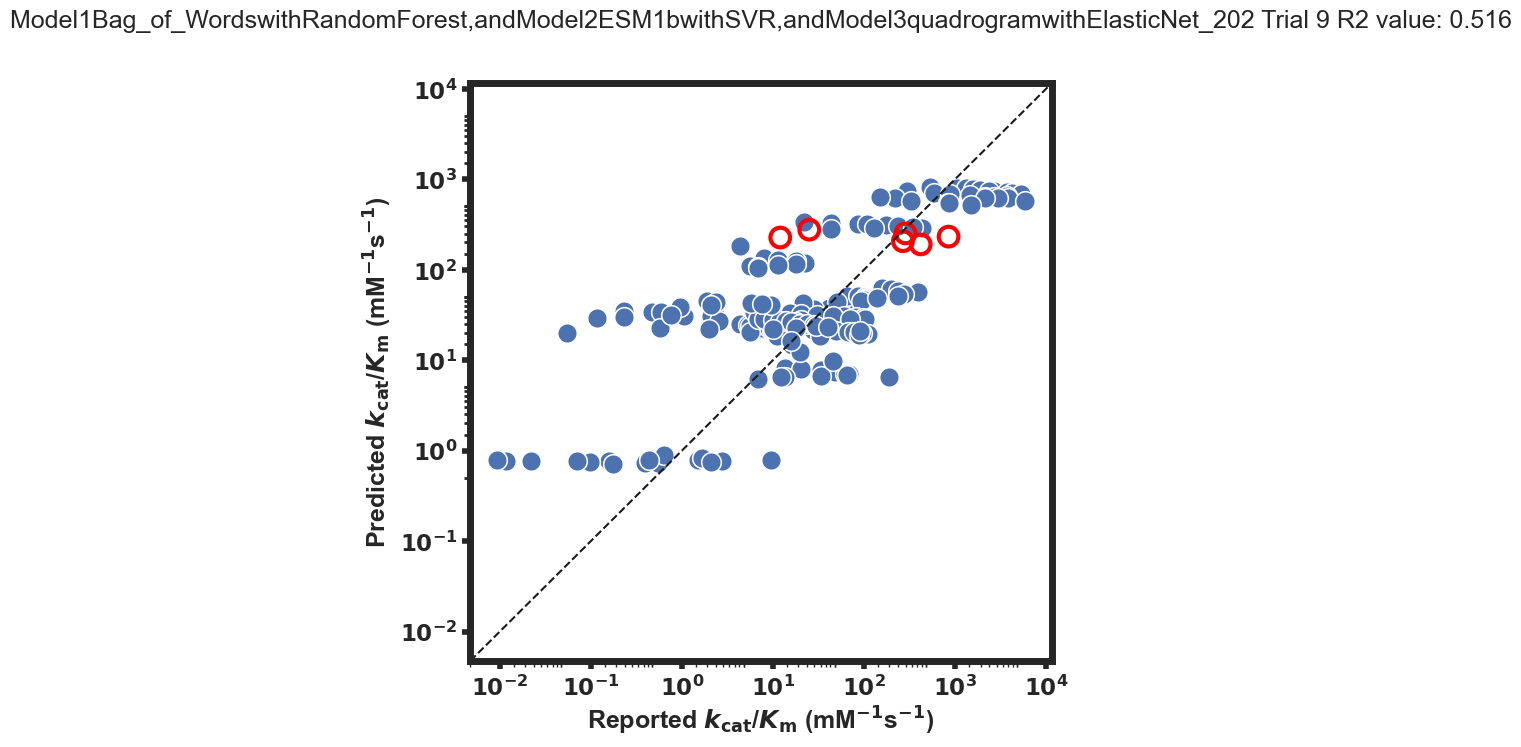

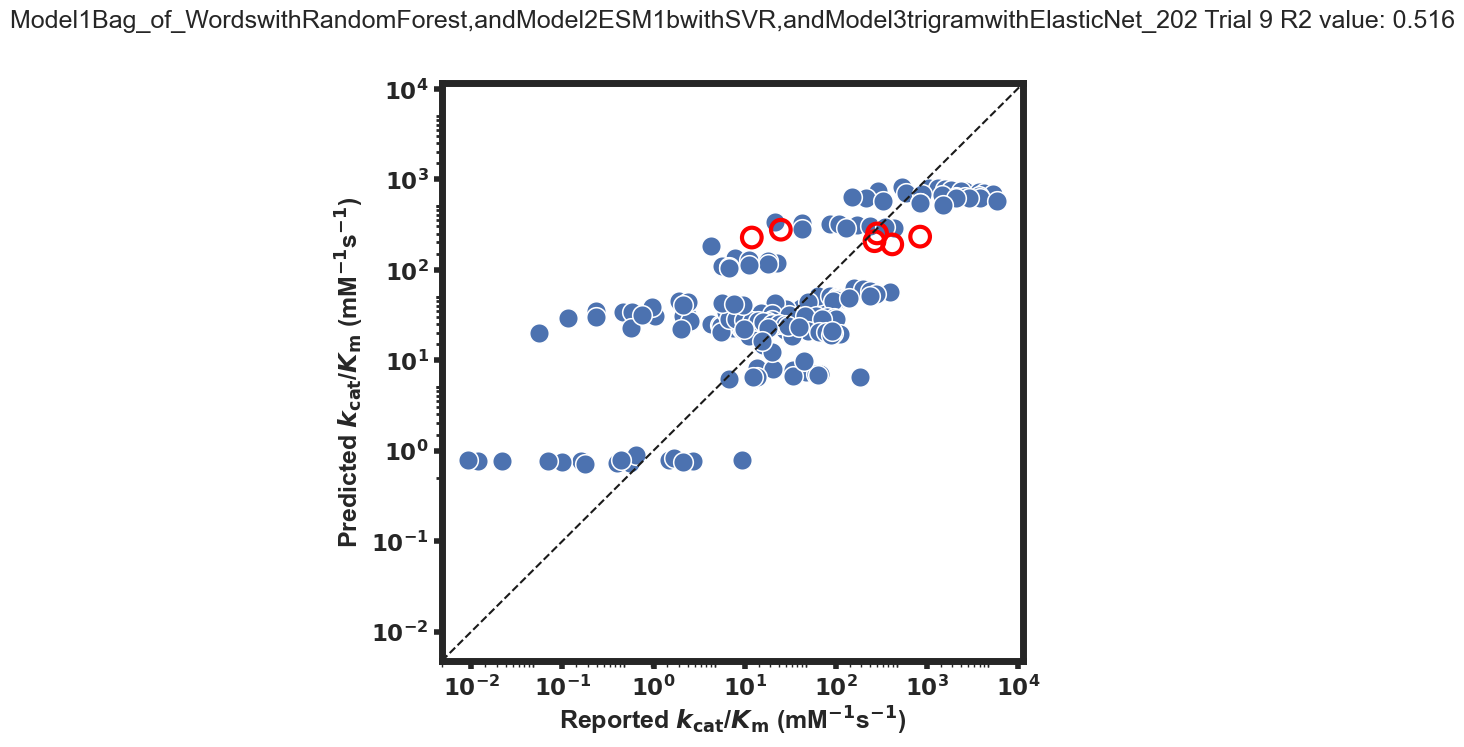

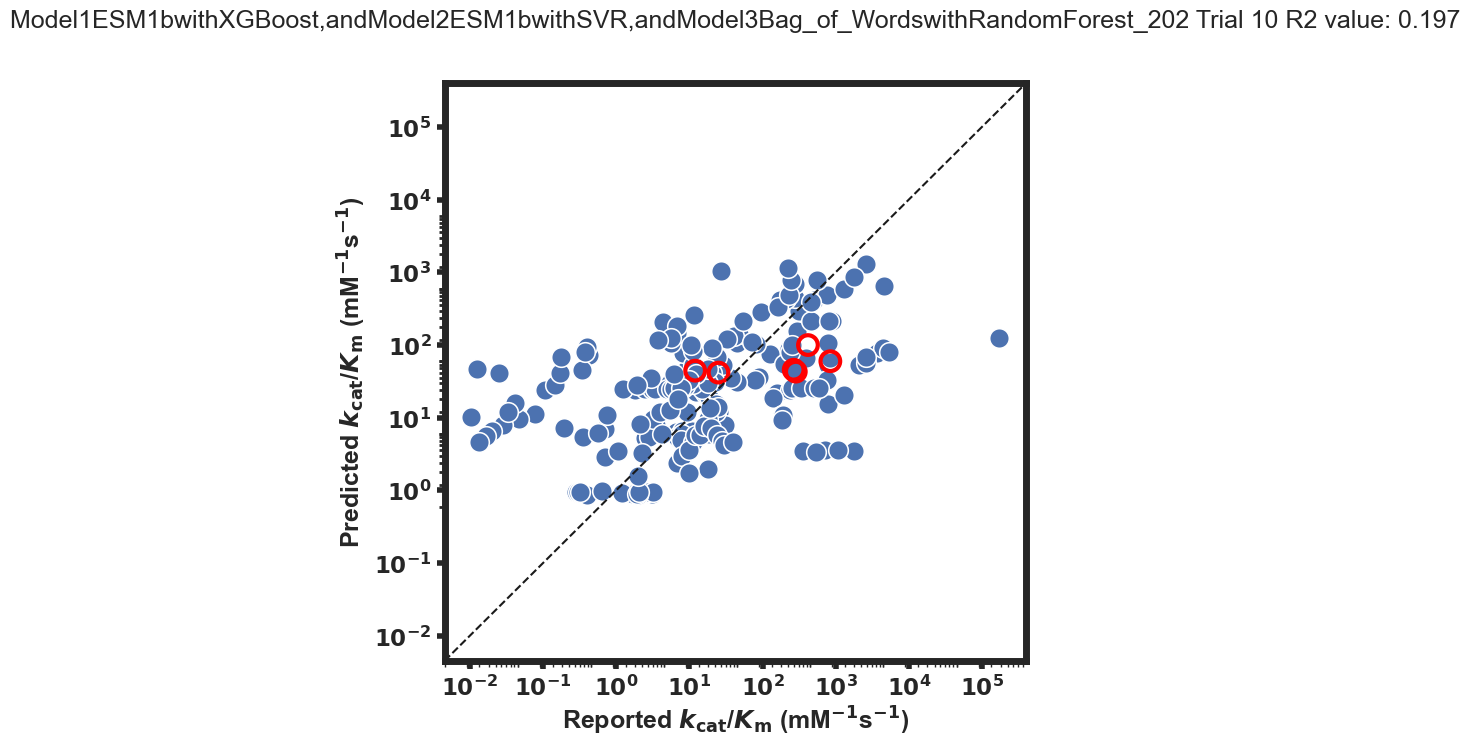

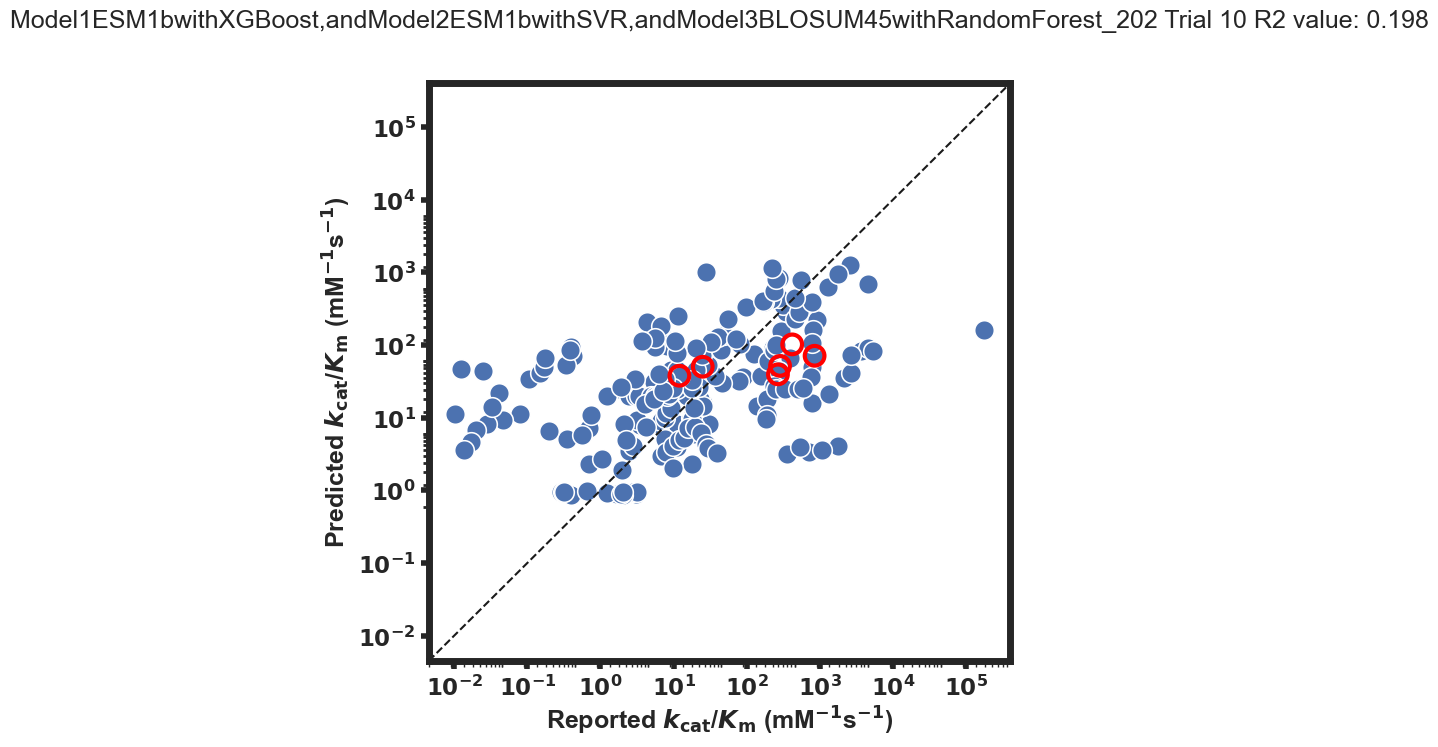

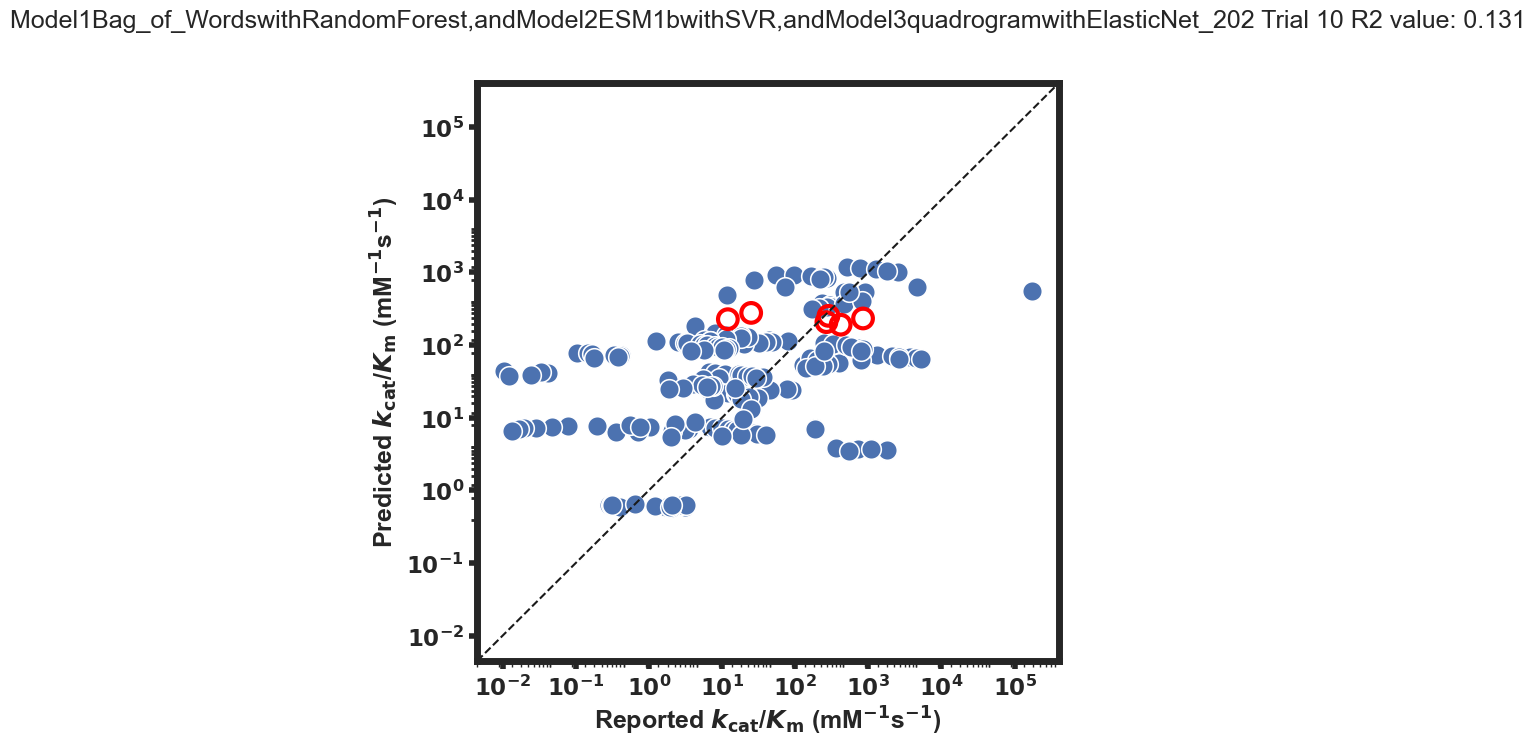

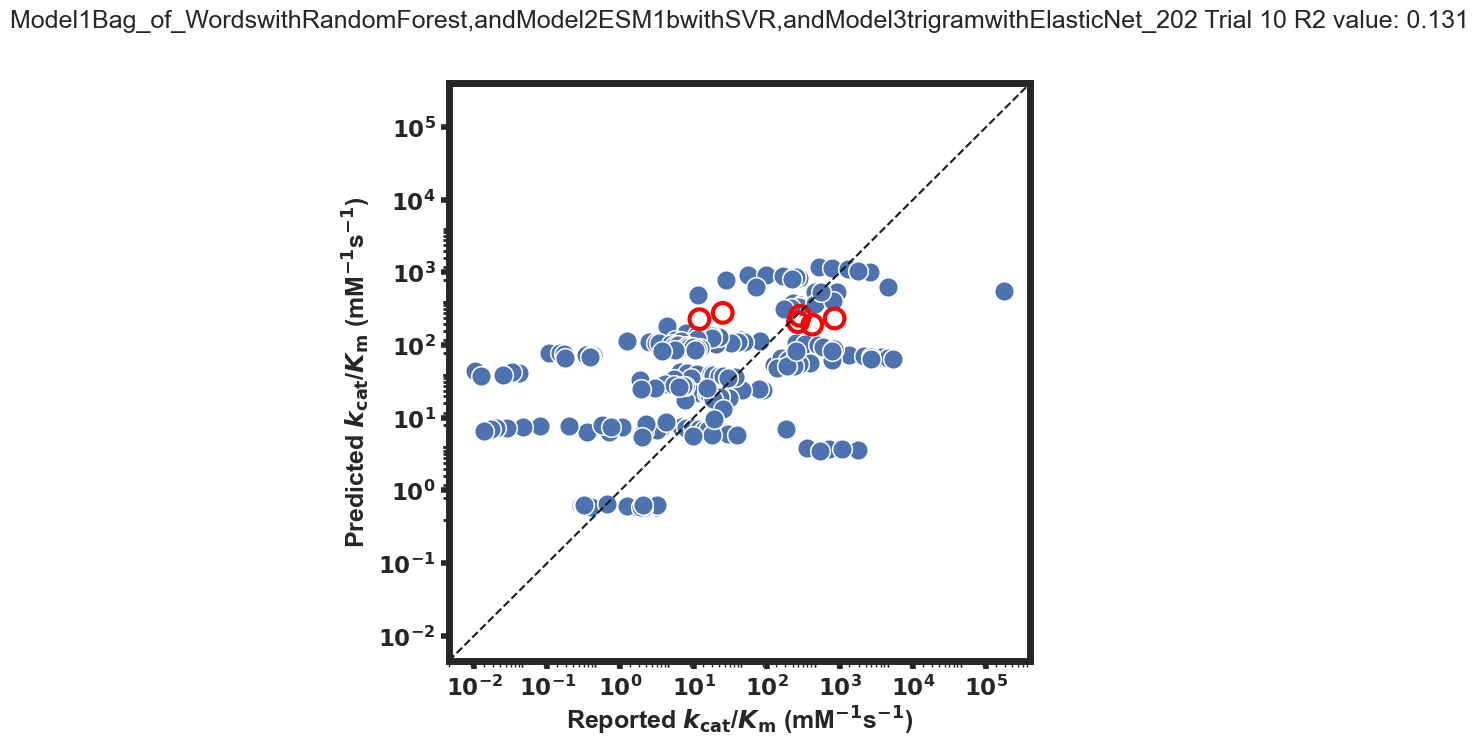

In [27]:
for trial in df_val:
    for model in model_name_list:
        r2 = r2_score(df_val[trial]['y value'].values, df_val[trial][model].values)
        plot_models(df_val[trial][model].values, df_val[trial]['y value'].values, model.replace(':', '').replace(' ', ''), r2 ,trial,y_hybrid_value,
                   df_hybrid_mean[model].values,df_hybrid_std[model].values )

In [ ]:
i = 0
for trial in  df_val:
    for model_name in model_name_list:
        df_model = df_val[trial][[model_name, 'y value']]
        r2 = r2_score(df_model ['y value'], df_model[model_name])
        r2 = (round(r2, 2))

        df_plotting = df_clean.iloc[val_ind_list[i]]
        df_plotting[model_name] = 10**df_val[trial][model_name].values
        
        sequence_list = df_plotting['Sequence'].unique()
        for seq in sequence_list:
            df_temperature_plotting=np.nan
            reaction_analyzer(seq, df_plotting, model_name, df_temperature_plotting,r2, trial)
            
    i = i + 1

